In [196]:
using Pkg
Pkg.add(url="https://github.com/YuriMiyamori/ContinuousWavelets.jl")

   Updating git-repo `https://github.com/YuriMiyamori/ContinuousWavelets.jl`


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [a98d9a8b] + Interpolations v0.13.2
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [1]:
using DataFrames, DataFramesMeta, CSV
using NPZ
using Random, Statistics
using DSP,FFTW, AbstractFFTs,Interpolations
using Wavelets
using ContinuousWavelets

using PyPlot
plt.style.use("seaborn-whitegrid");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 12
rcParams["figure.figsize"] = [16,16]
rcParams["figure.dpi"] = 220;

In [2]:
BASE_DIR = "/home/yuri/kaggle/g2net-gravitational-wave-detection/"

"/home/yuri/kaggle/g2net-gravitational-wave-detection/"

In [3]:
train_label_df = CSV.read(joinpath(BASE_DIR, "training_labels.csv"), DataFrame)
train_label_df[:, :fname] = train_label_df[:, :id] .* ".npy"

BASE_DIR = "/home/yuri/kaggle/g2net-gravitational-wave-detection/"
sample_dir = "train/0/0/0/00000e74ad.npy"
sample_dir2 = "train/0/0/0/00001f4945.npy"
const sampling_rate = 2048
const dt = 1 / sampling_rate

0.00048828125

In [4]:
const max_safe_exponent = 700.0

function fade!(signal, fade_length=0.06)
    n = length(signal)
    n0 = floor(Int, length(signal) * fade_length)
    n1 = n - n0
    t = collect(1:n)
    
    sigmoid(x)=1 ./(1 .+exp(-14 .*(x .-0.5)))
    for i in 1:n0
        signal[i] = signal[i] * sigmoid(i/n0)
    end
    for i in n1:n
        signal[i] = signal[i] * sigmoid((n-i)/(n-n1))
    end
    signal
end

fade! (generic function with 2 methods)

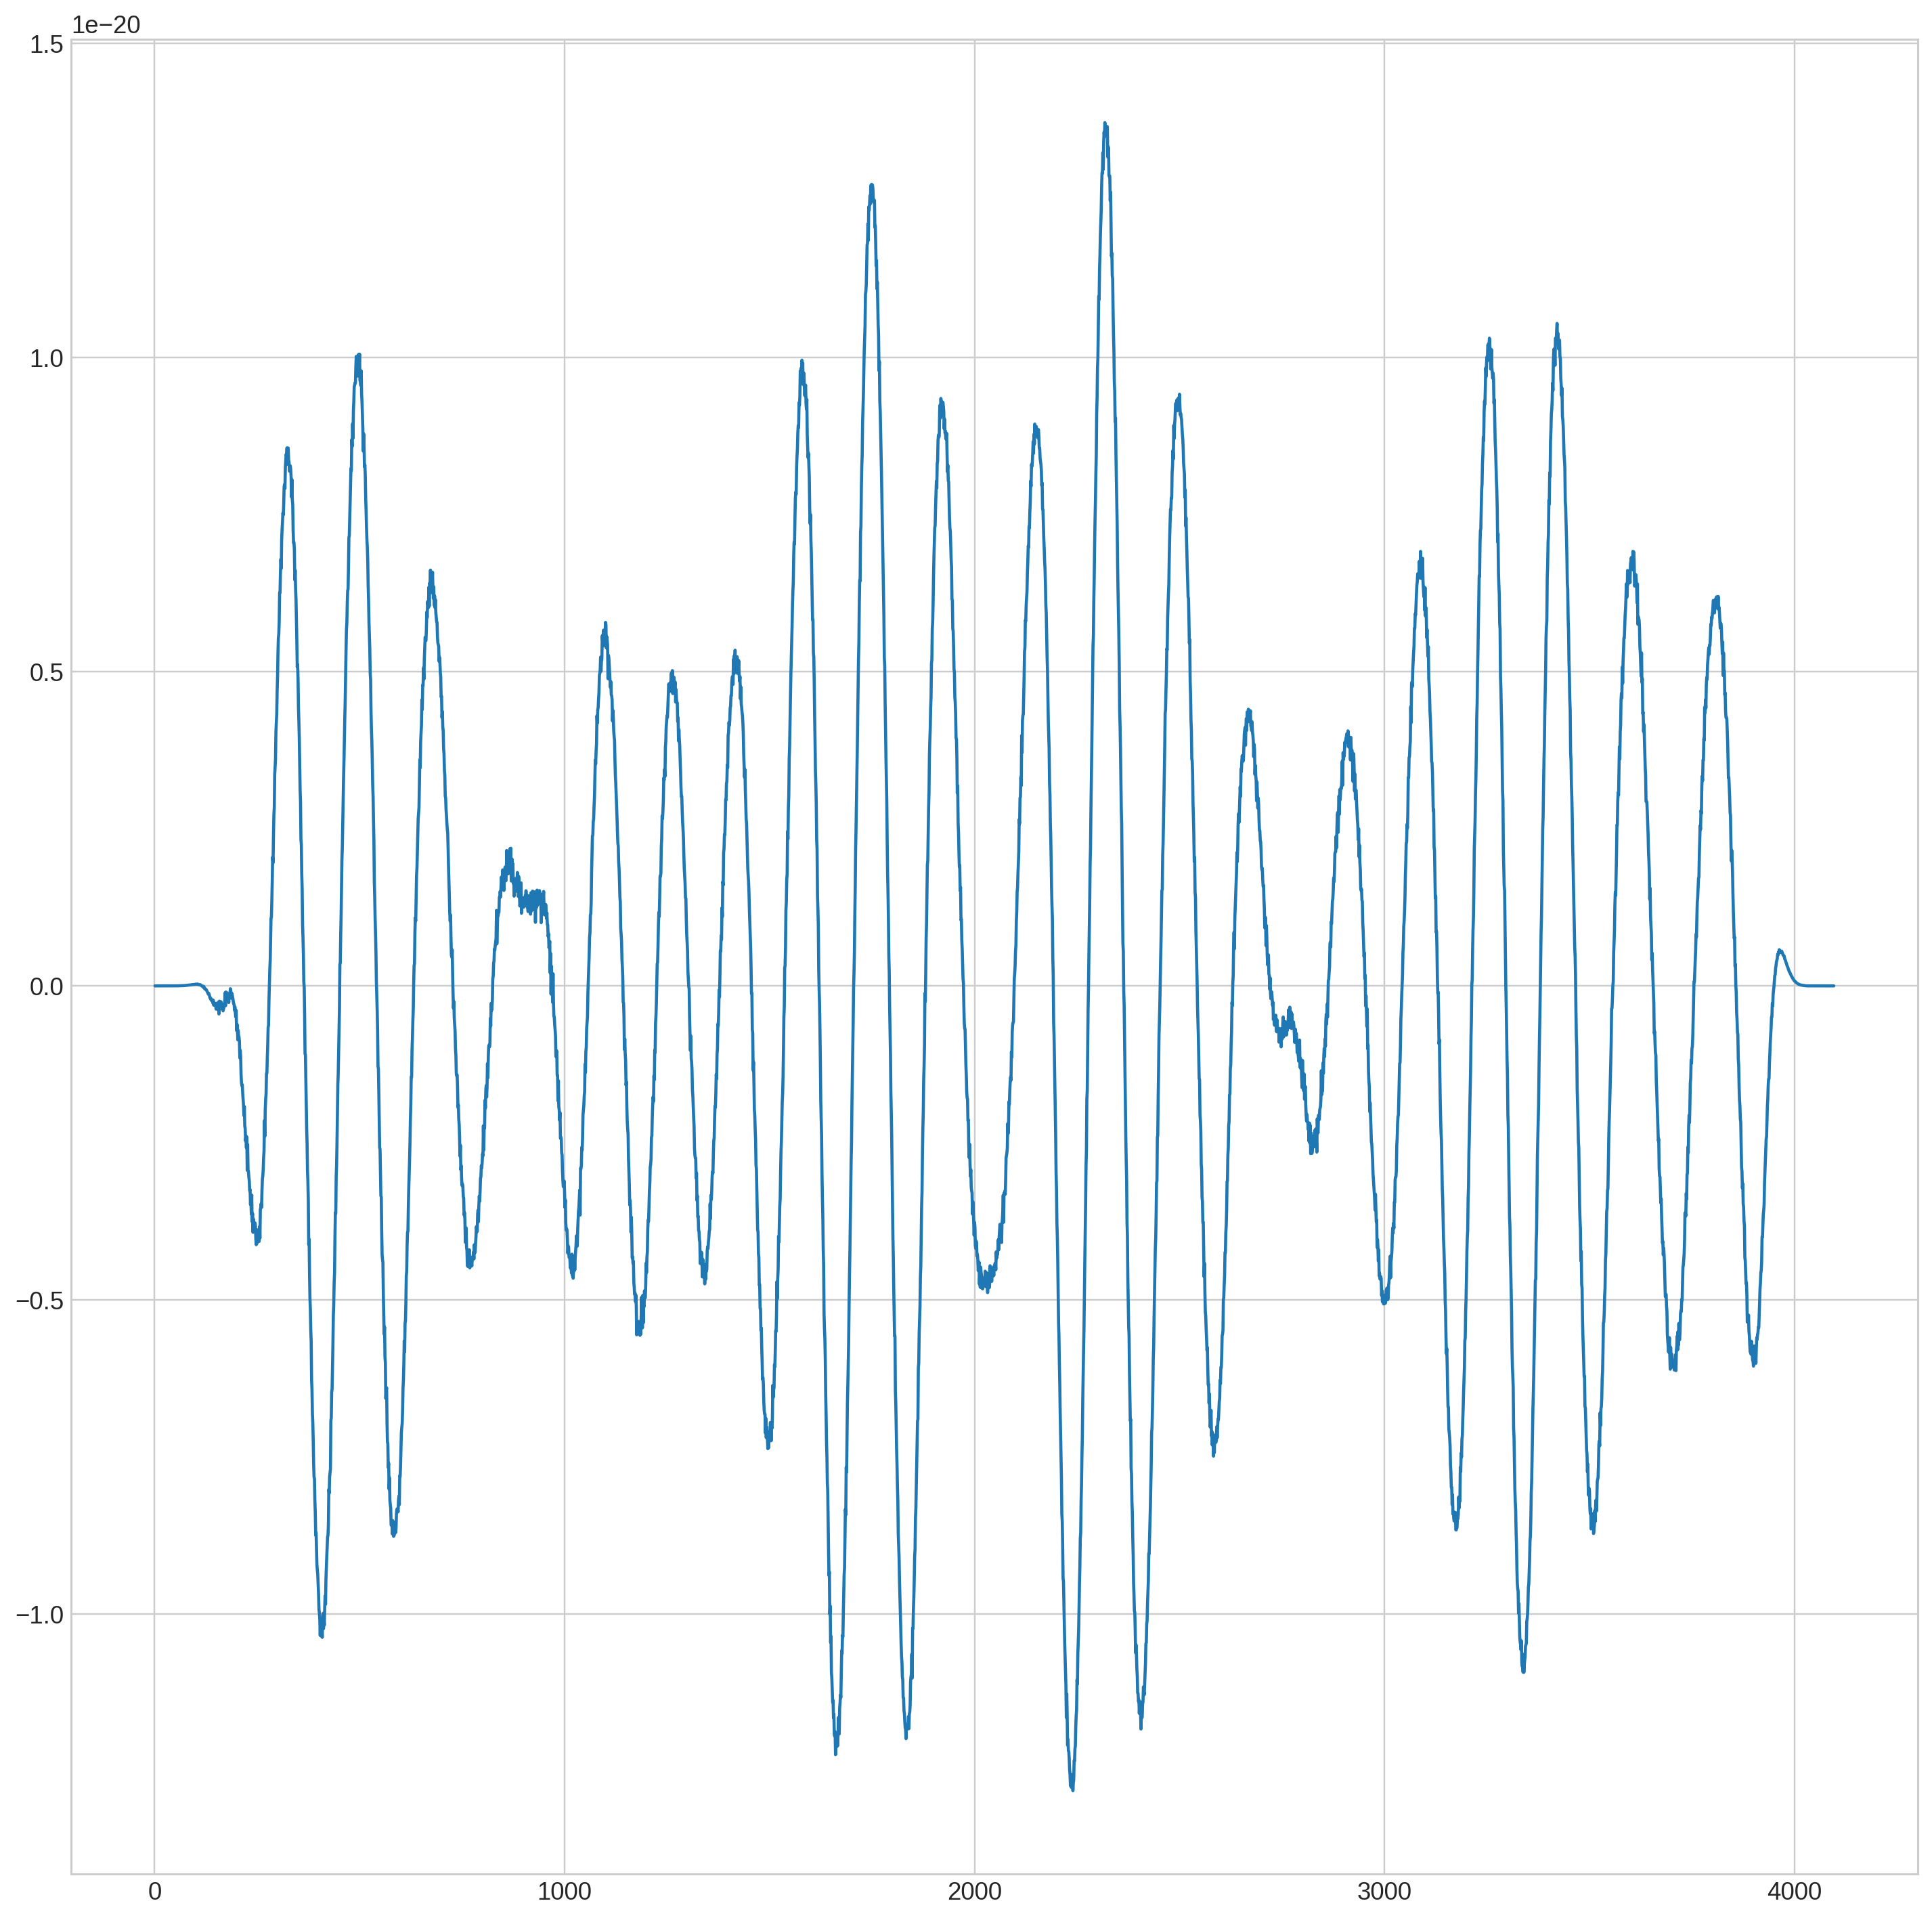

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa9a0864a8>

In [5]:
function read_npy_data(path, res=nothing)
    if isnothing(res)
        res = Float64[]
    end
    data = npzread(path) |> x-> reshape(x, 3, sampling_rate*2) |> transpose |> Array
    for i in 1:3
        data[:,i] = fade!(data[:,i])
    end
    res = cat(res, data,dims=1)
end
data = Float64[]
for i in 1:1
    file_name = "train/0/0/0/$(train_label_df[i, :id]).npy"
    data = read_npy_data(joinpath(BASE_DIR, file_name), data)
end

fig, ax = plt.subplots()
ax.plot(1:length(data[:,1]), fade!(data[:,1], 0.08))

In [6]:
function sample_plot(data, flg)
    n = 2048
    fig, axes = plt.subplots(6,1)
    for (i,j) in zip(1:2:5, 1:3)
        ax1 = axes[i]
        ax2 = axes[i+1]
        c = wavelet(Morlet(π), β=2);
        res = ContinuousWavelets.cwt(data[:,j], c)
        # plotting
        freqs = getMeanFreq(ContinuousWavelets.computeWavelets(n, c)[1])
        freqs[1] = 0
        s = size(res, 2)
        res_p = abs.(res)' # |> a-> a[s:-1:1, :] |> Array
        res_p = res_p ./ sum(res_p,dims=1)
        # @show(sum(res_p,dims=1))
        # ax1.imshow(res_p, aspect=2048/37/4, cmap="jet")
        ax1.contour(res_p, aspect=2048/37/4, cmap="jet")
        
        ax2.scatter(t, data[:,j], s=0.2)
        axes[1].set_title(flg)
    end
end

fnames = readdir(joinpath(BASE_DIR, "train/0/0/0/"), join=false)
fpaths = readdir(joinpath(BASE_DIR, "train/0/0/0/"), join=true)

data = Float64[]
data_in_sig = Float64[]
for (fname, fpath) in zip(fnames, fpaths)
    if train_label_df[train_label_df[:, :fname] .== fname, :target] |> first  == 0
        data = read_npy_data(fpath, data)
    else
        data_in_sig = read_npy_data(fpath, data_in_sig)
    end
end
h = data[:, 1]
h_in_sig = data_in_sig[:, 1]
        
"""
sample_dir = "train/0/0/0/00000e74ad.npy"
data = read_npy_data(joinpath(BASE_DIR, sample_dir))
data2 = read_npy_data(joinpath(BASE_DIR, sample_dir2))
# sample_dir = "train/0/0/0/00001f4945.npy"
"""
# d2 = read_npy_data(joinpath(BASE_DIR, sample_dir))
# h = data[:,1]
# h = fade(h)

const t = (1:length(h)) .*dt  |> collect
"""
h2 = data[:,1]
hh = vcat(h, h2)
hh = fade(hh)
"""

# sample_plot(data, 1)
# sample_plot(d2, 0)
#l=@layout [a{.3h};b{.7h}]
#plot(p1,p2,layout=l)

"h2 = data[:,1]\nhh = vcat(h, h2)\nhh = fade(hh)\n"

In [23]:
size(h)  .- size(h_in_sig)

(20480,)

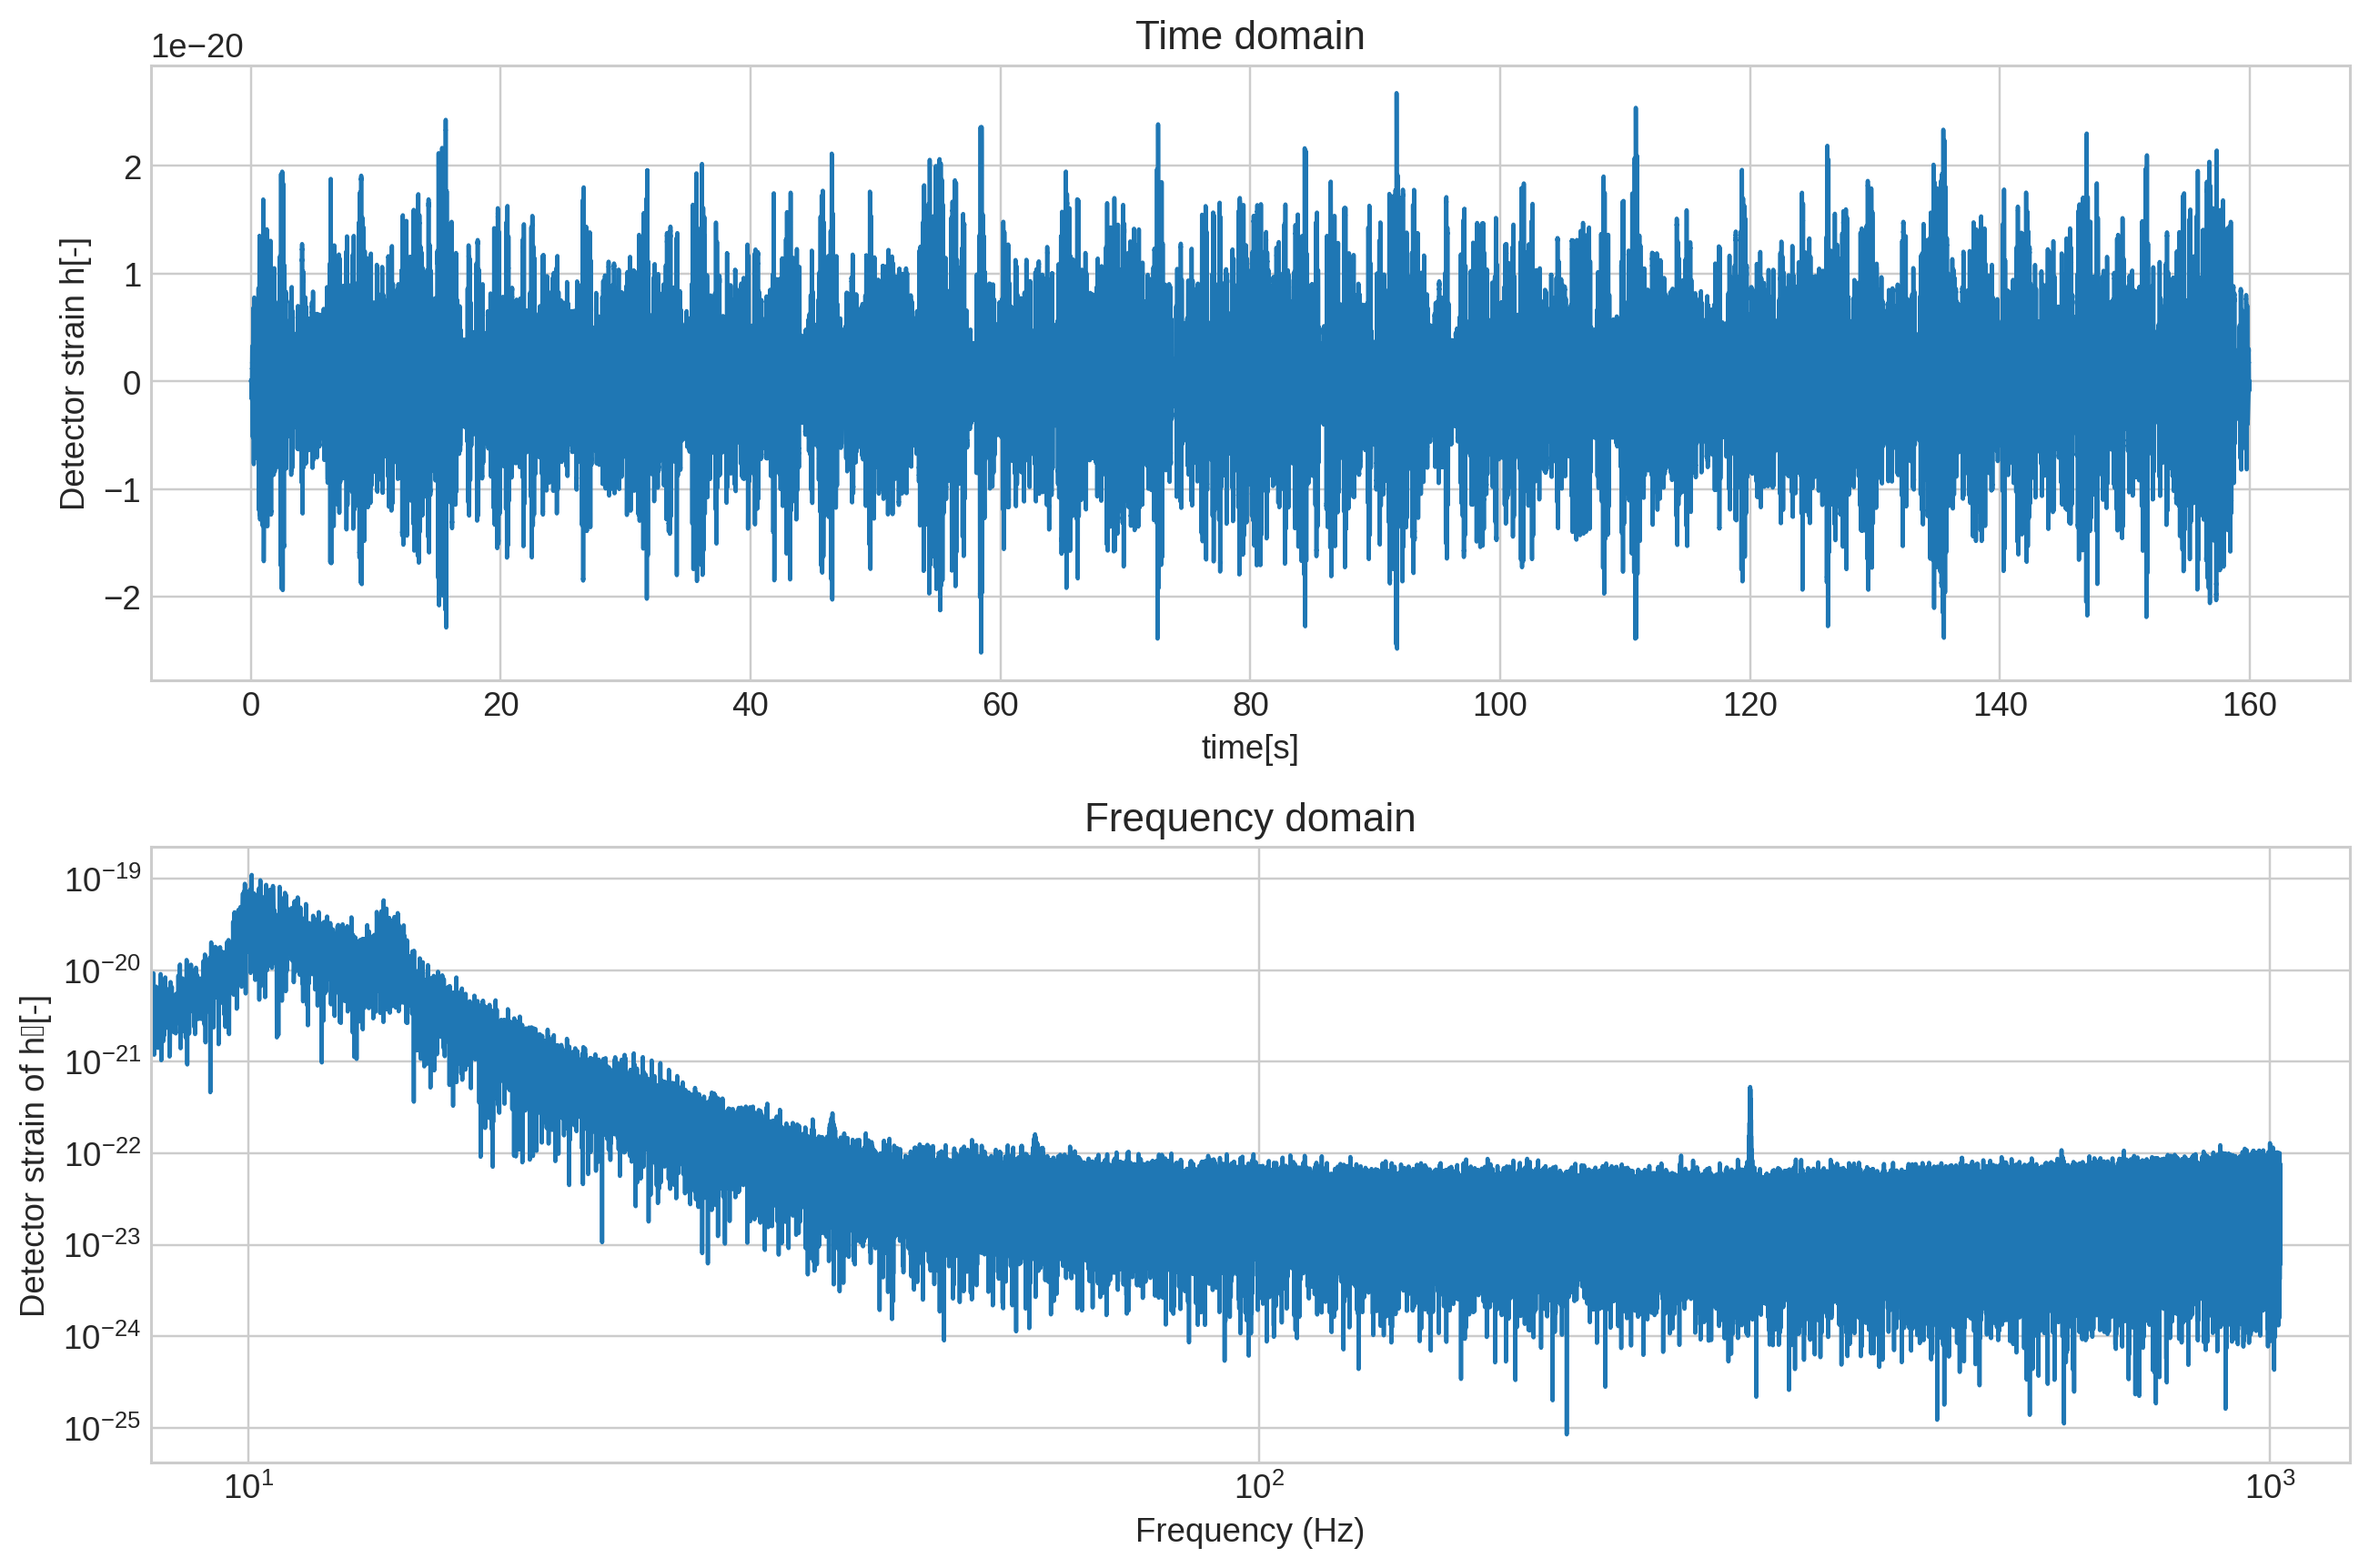

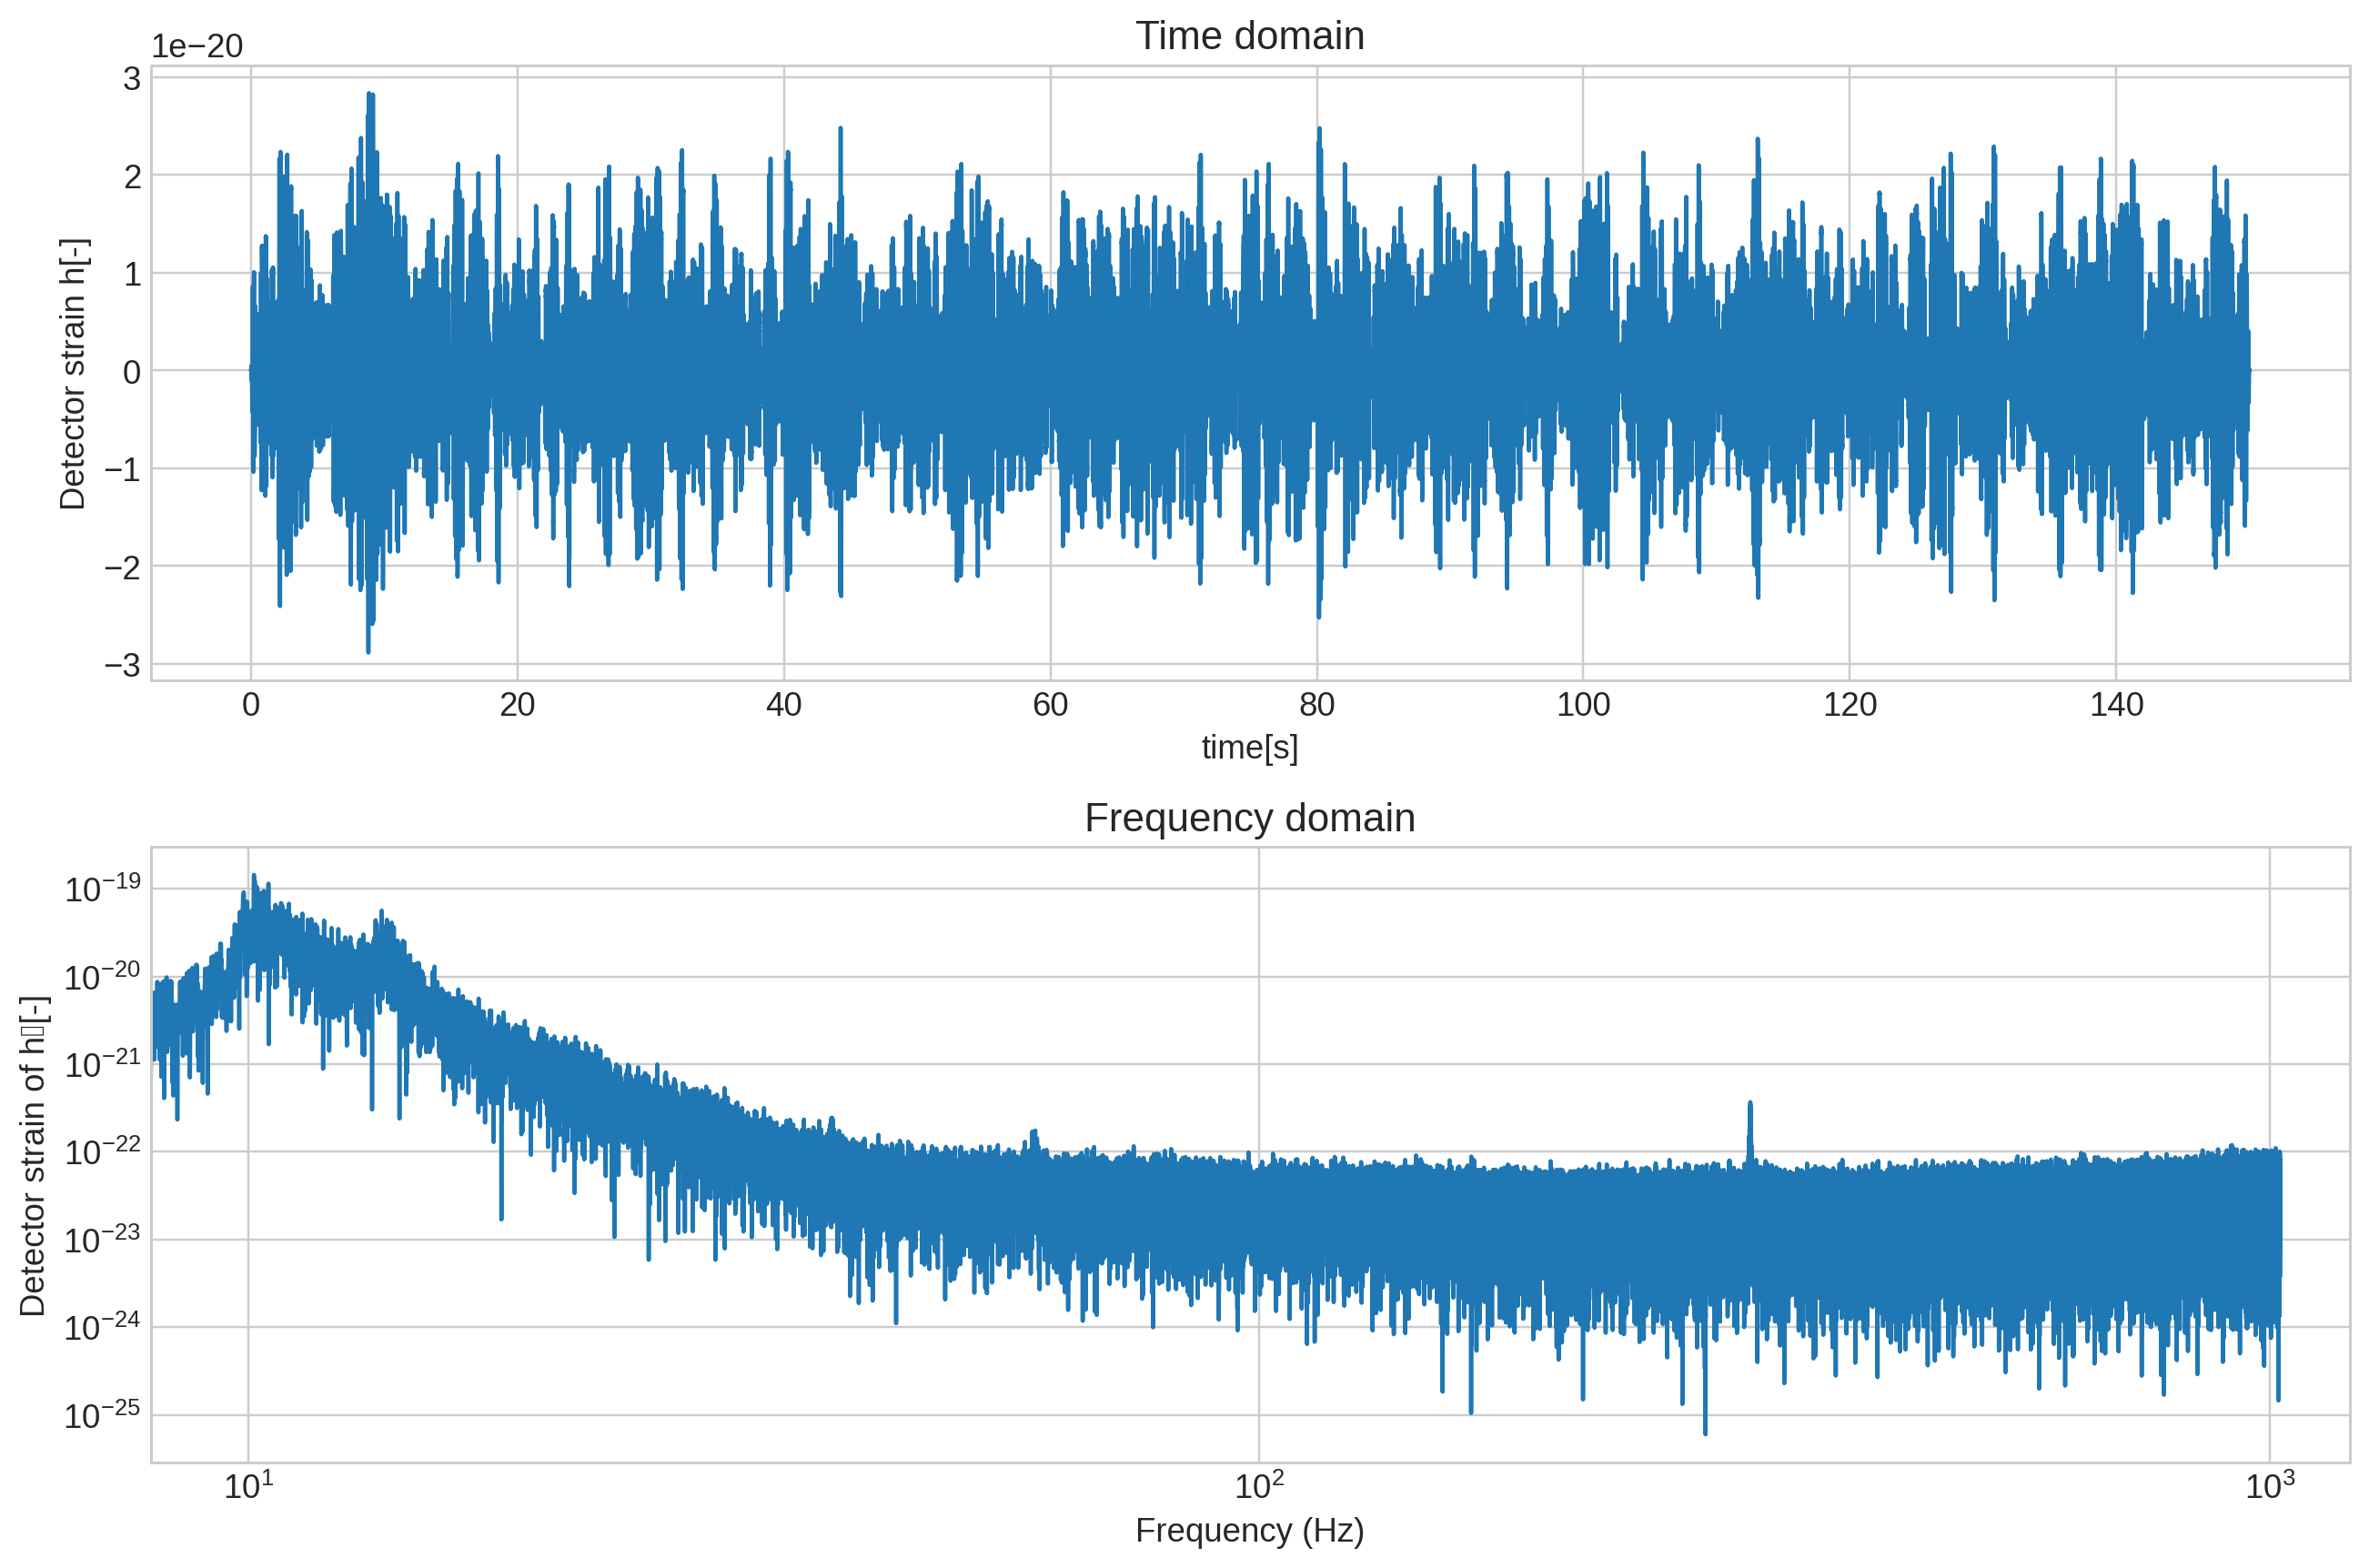

(PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ffa5c628940>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ffa5c5ee588>)

In [9]:
h̃ = dt * FFTW.rfft(h) 
h̃_in_sig = dt * FFTW.rfft(h_in_sig) 

function plot_td_and_fd(h, h̃, h̃2=nothing)
    frequencies = FFTW.rfftfreq(length(h), sampling_rate)
    t = (1:length(h)) .*dt  |> collect
    
    fig,(ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
    ax1.plot(t, h)
    ax1.set_xlabel("time[s]")
    ax1.set_ylabel("Detector strain h[-]")
    ax1.set_title("Time domain")
    #ax1.set_xlim((-1.1,1.1))
    ax2.plot(frequencies, abs.(h̃), label="h̃")
    if ~isnothing(h̃2)
        ax2.plot(frequencies, abs.(h̃2), label="h̃2", alpha=0.4)
        ax2.legend()
    end
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Detector strain of h̃[-]")
    ax2.set_title("Frequency domain")
    ax2.set_xlim((8,1200))
    fig.tight_layout()
    return ax1, ax2
end

plot_td_and_fd(h, h̃)
plot_td_and_fd(h_in_sig, h̃_in_sig)

size(noise_spectral_density_interpolator) = (163841,)
size(noise_spectral_density_interpolator) = 

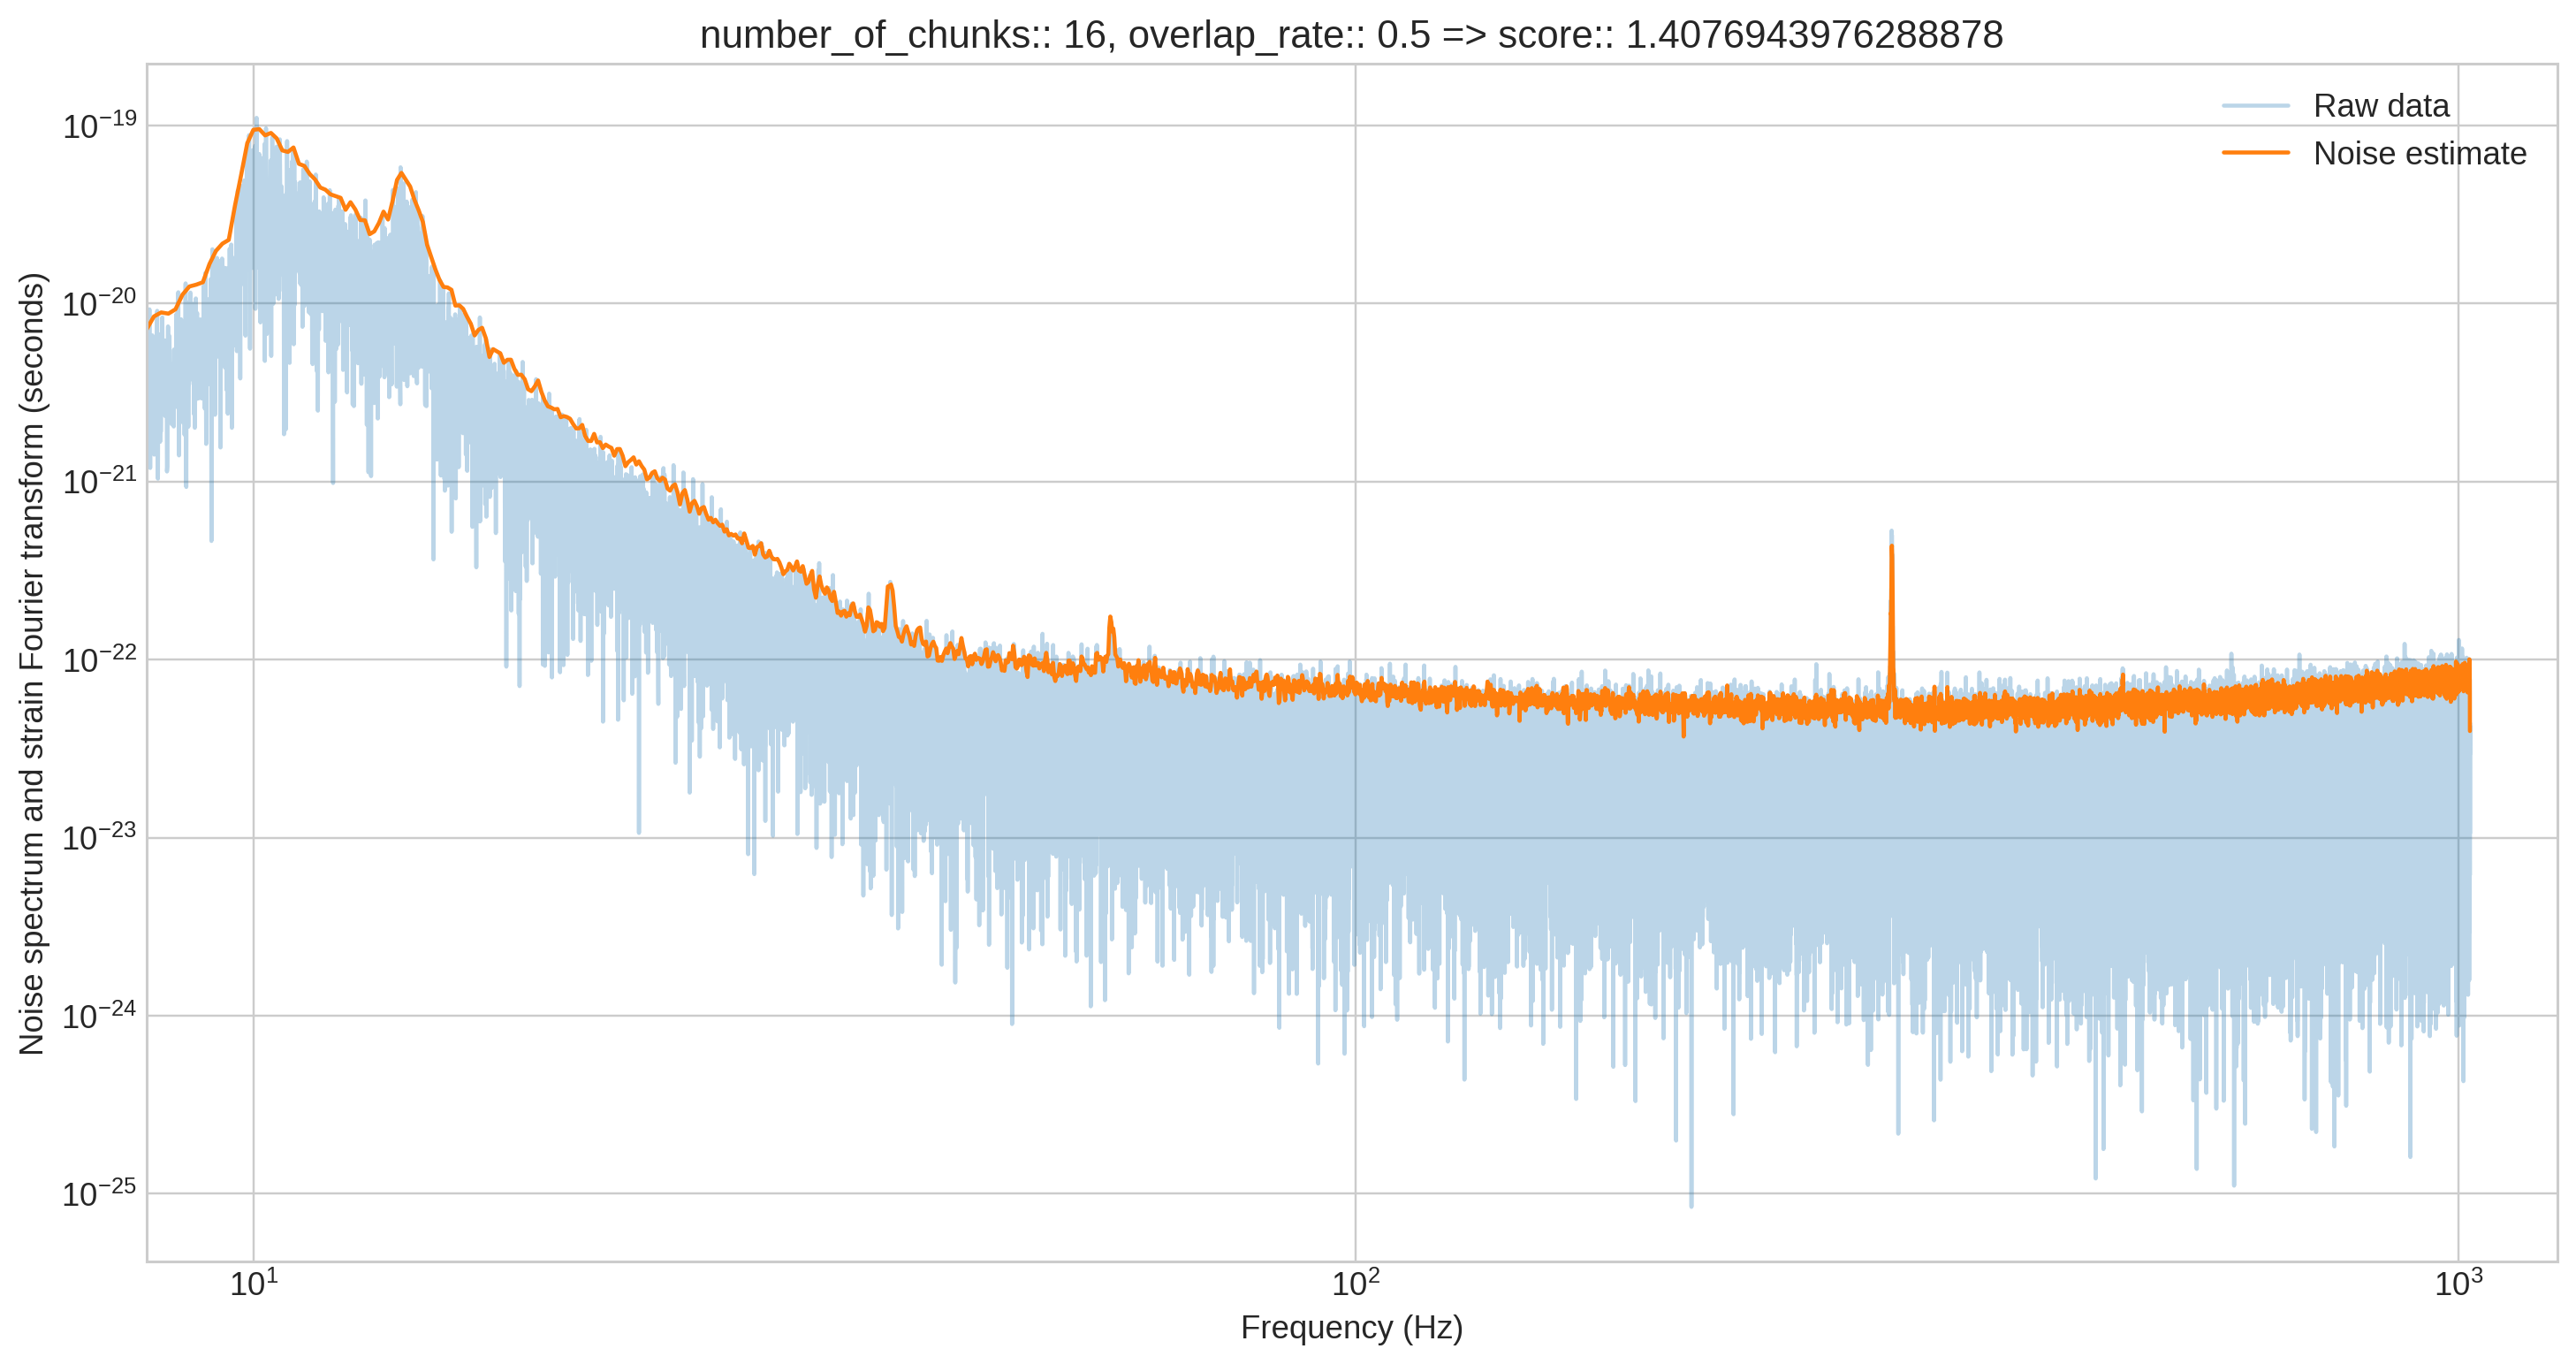

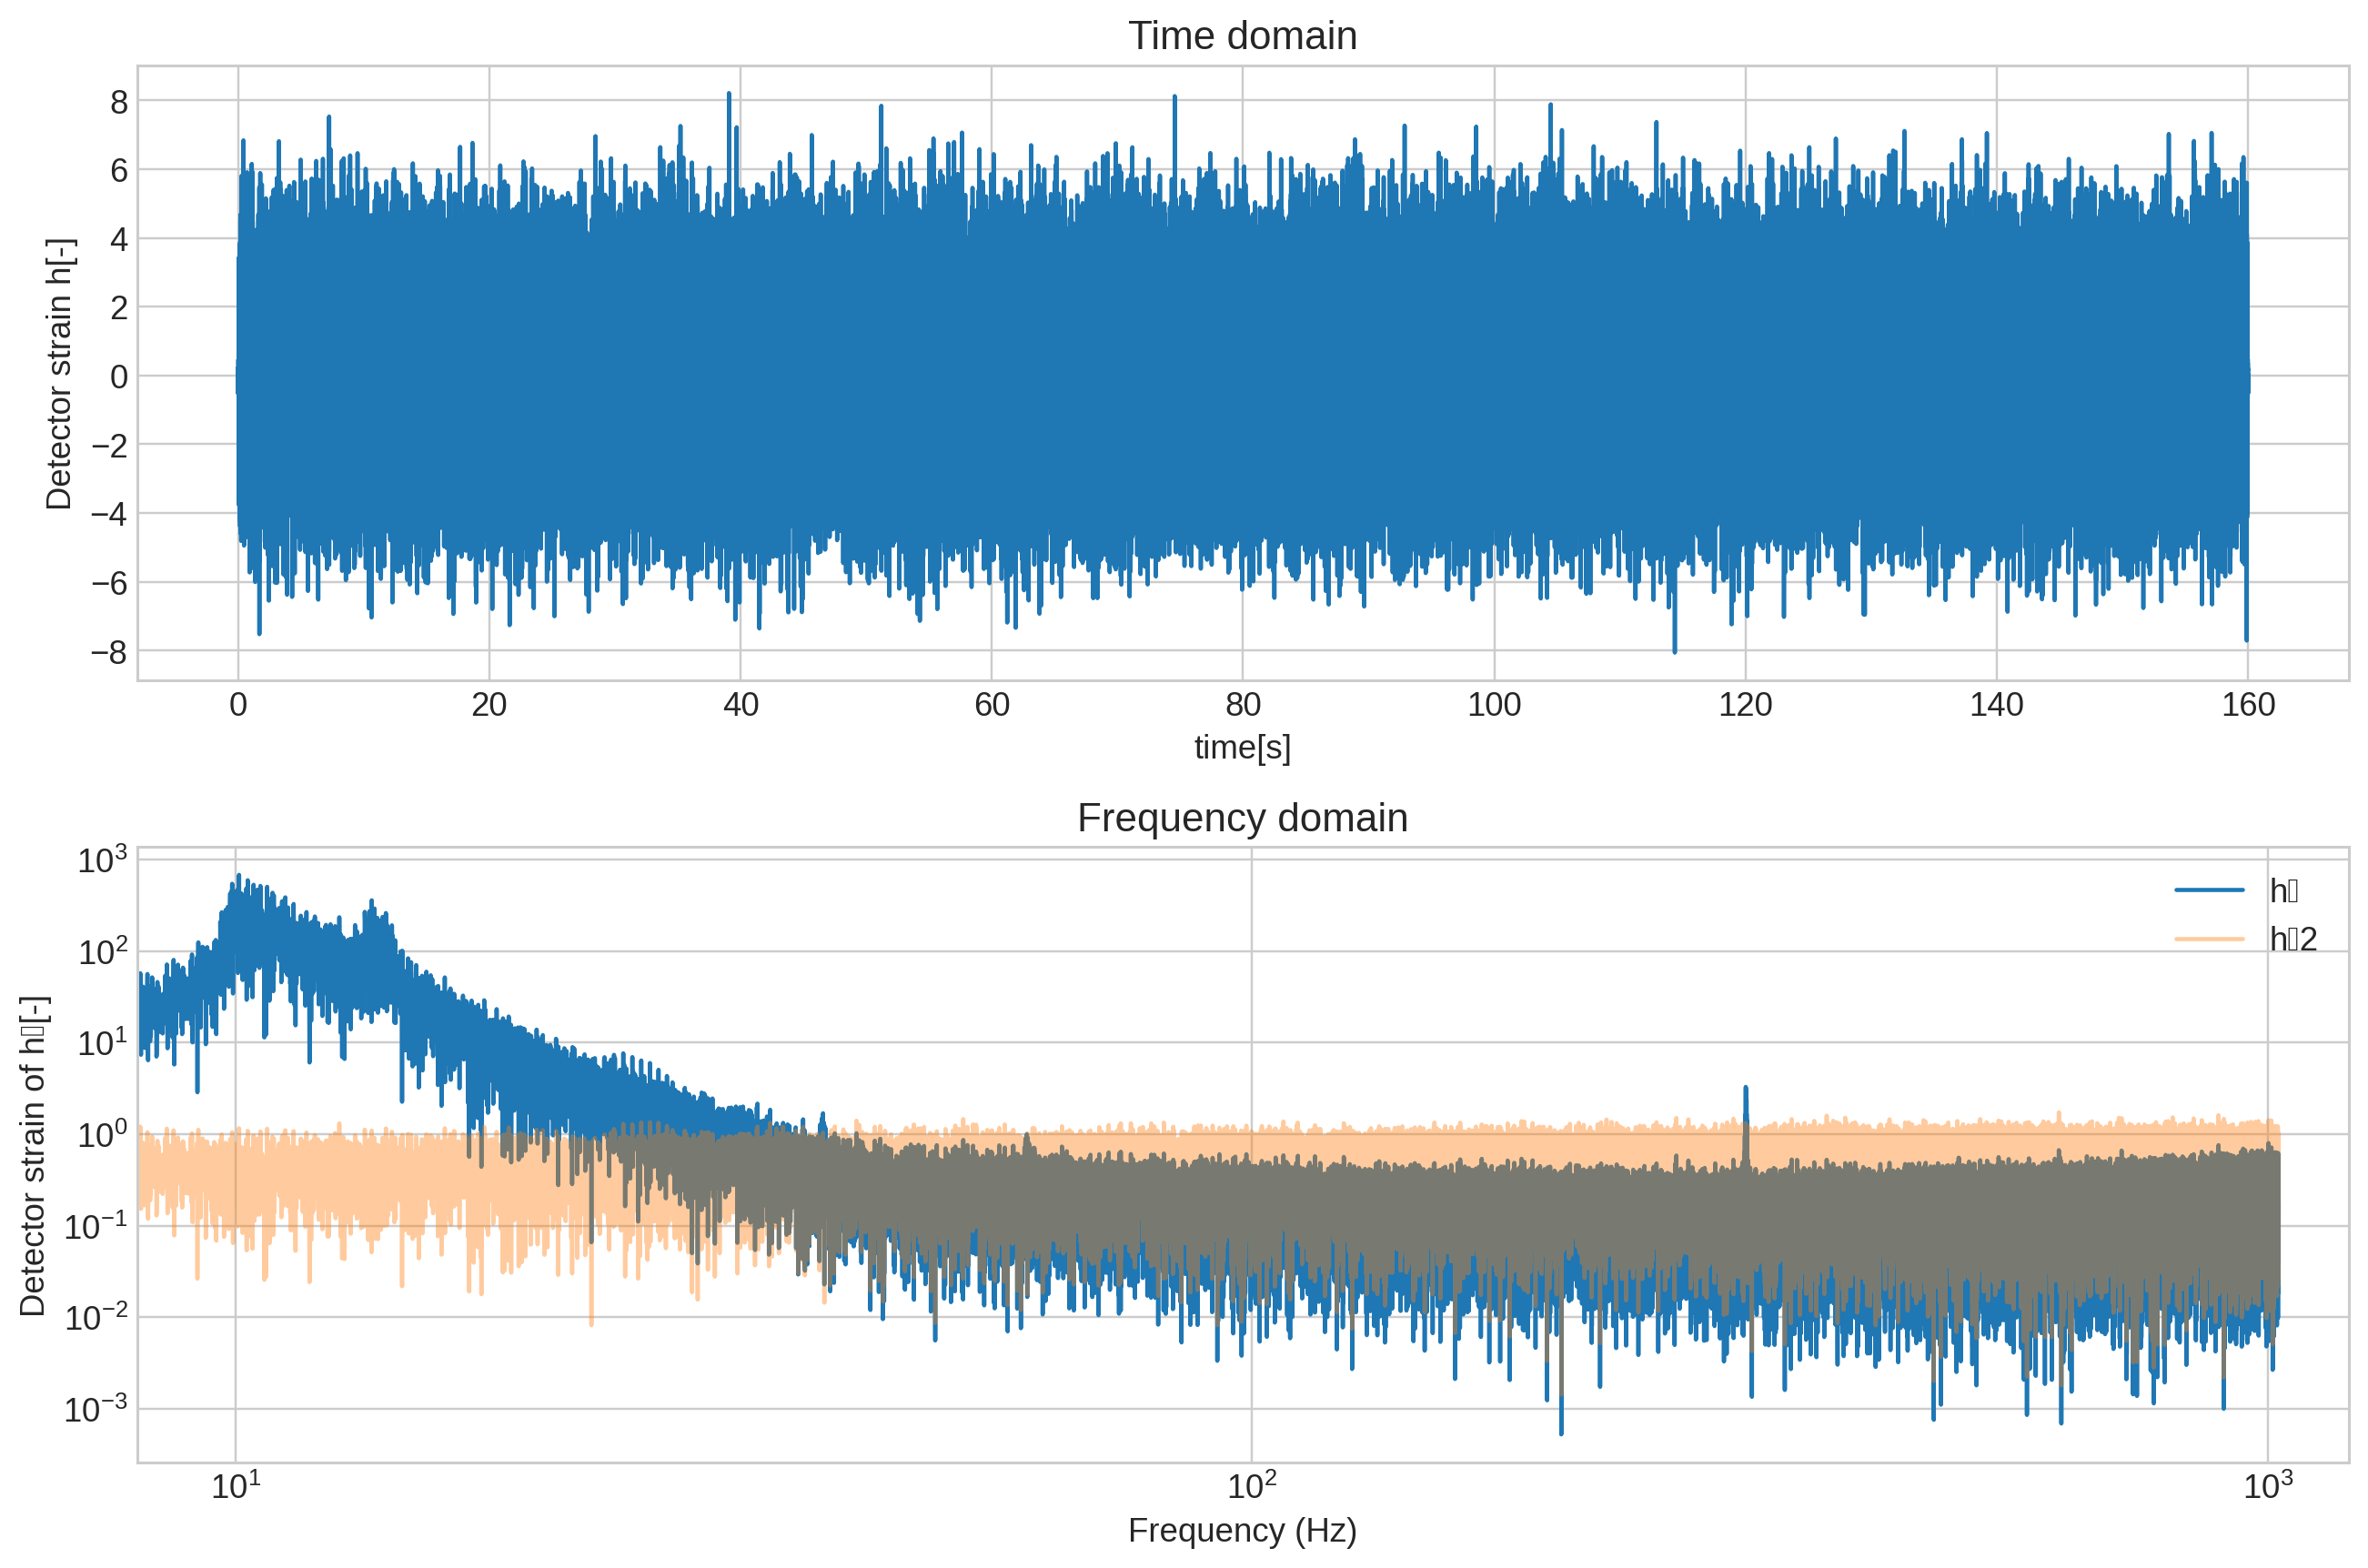

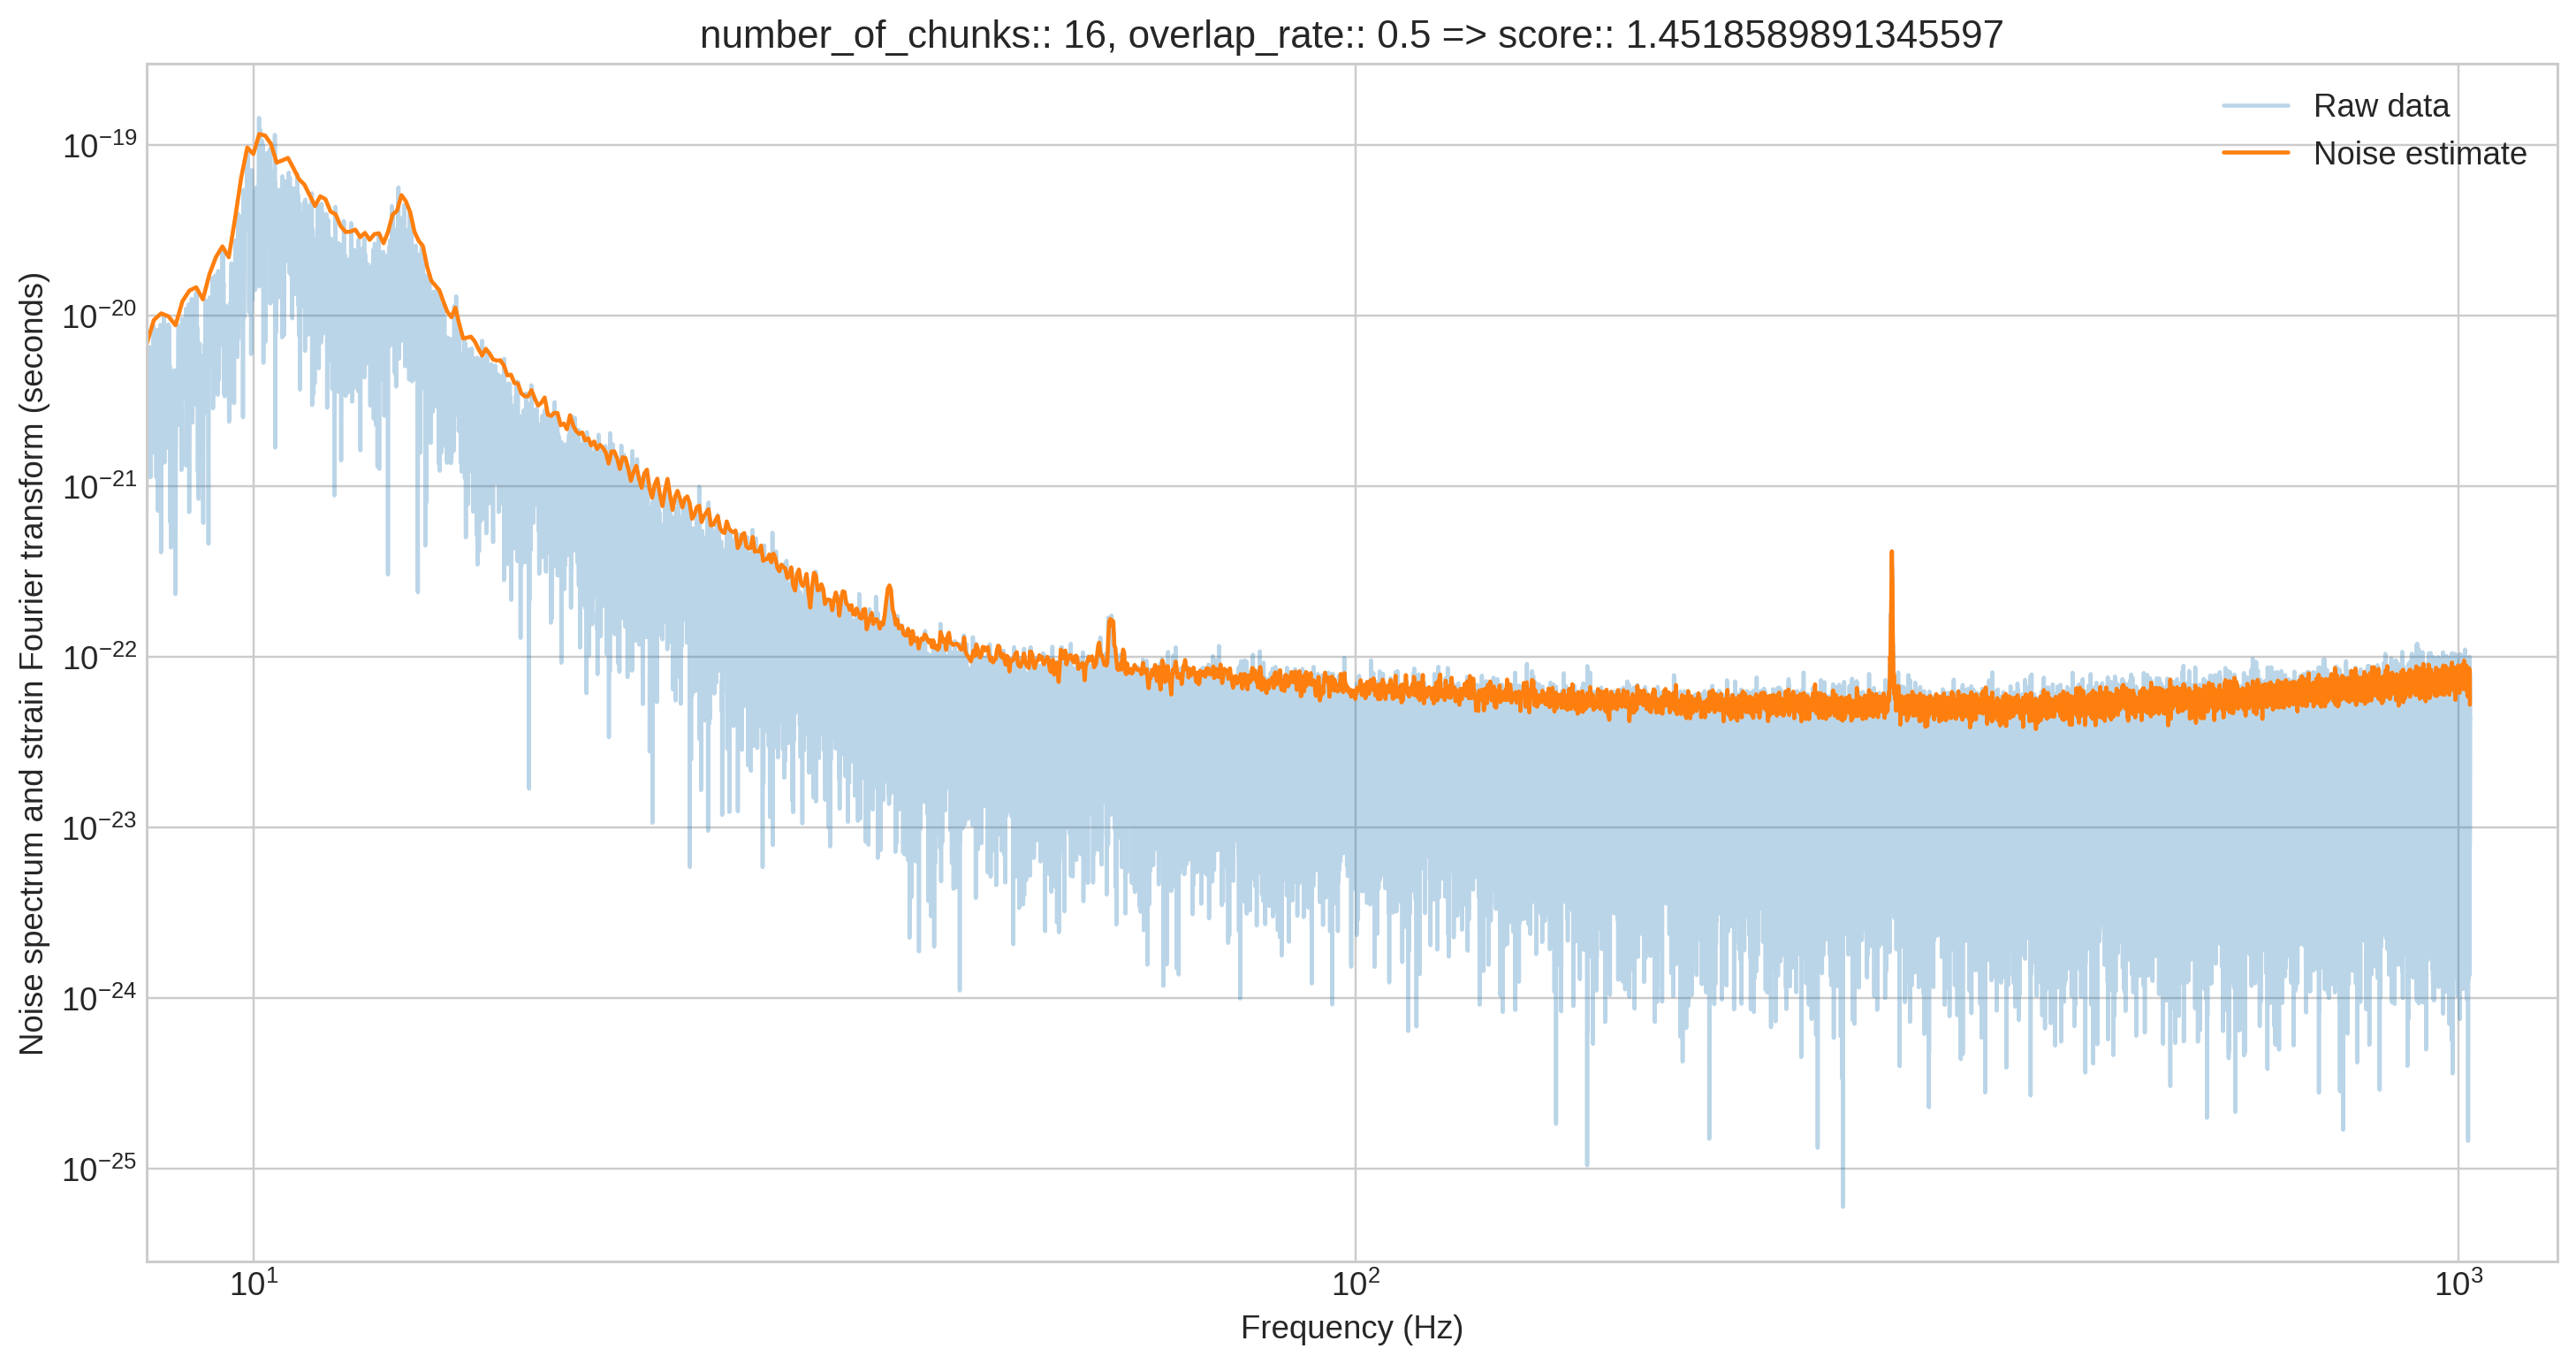

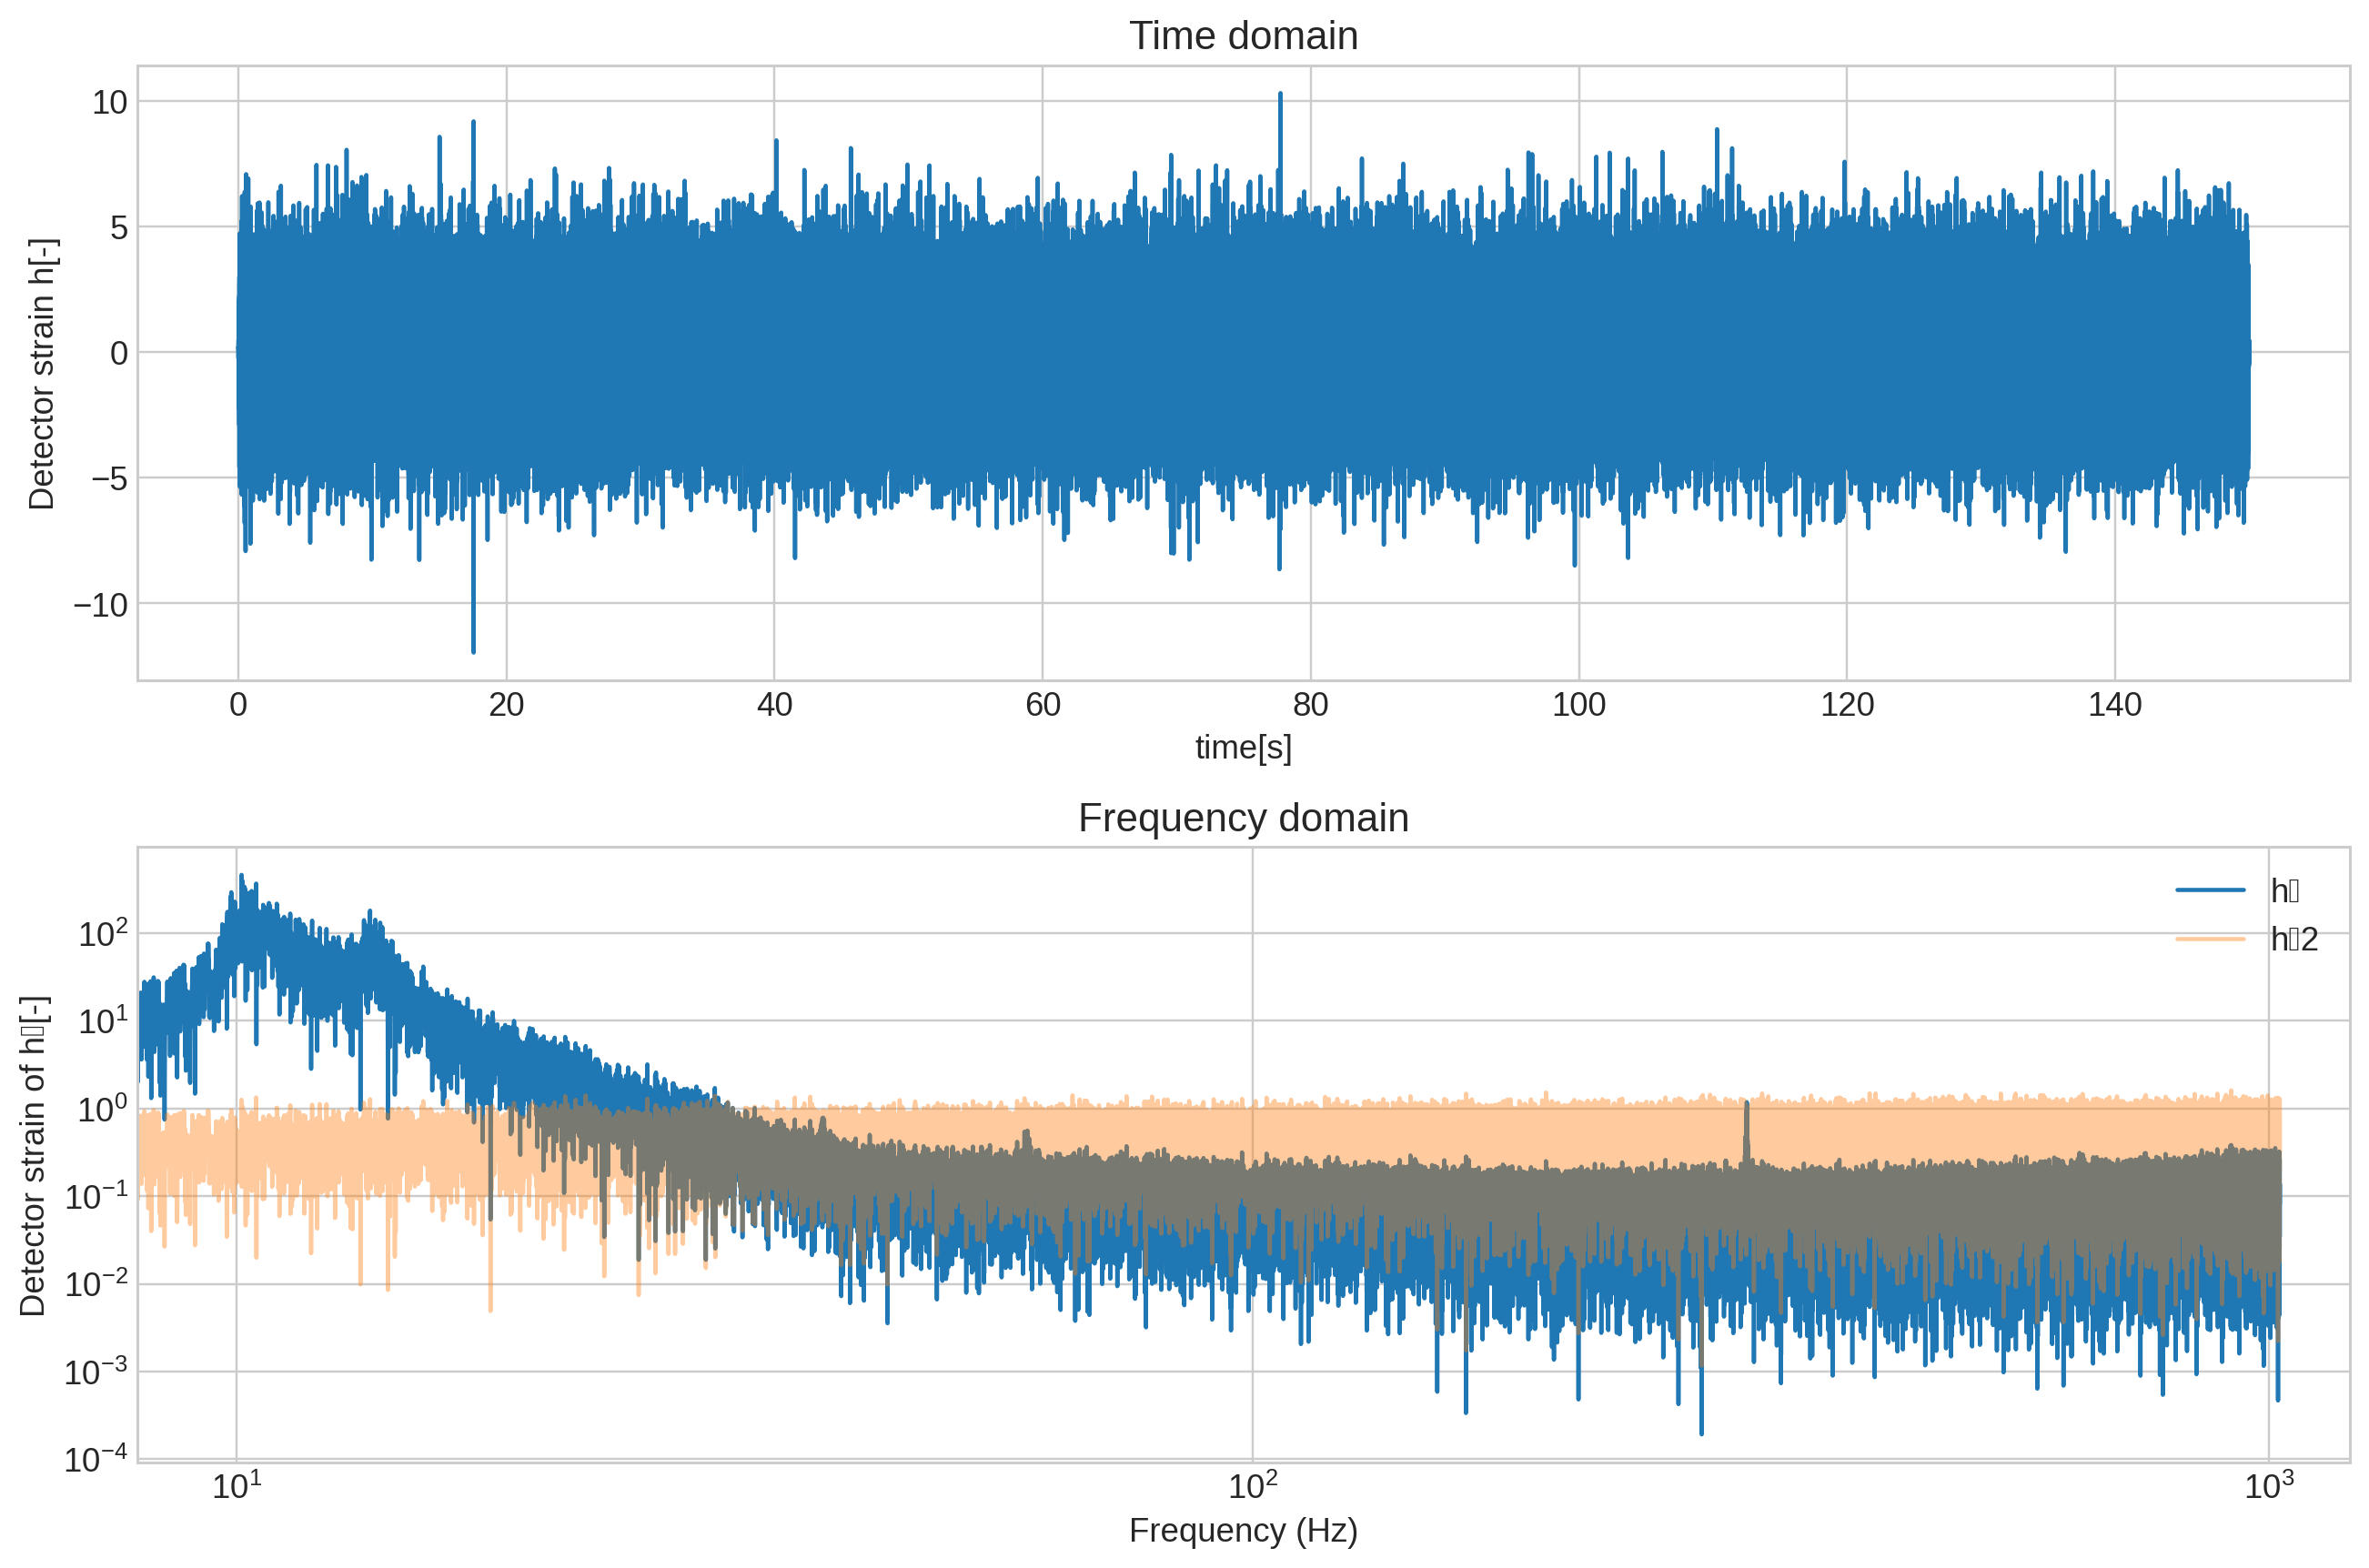

(153601,)


"for number_of_chunks in 2:8\n    noise_detect(number_of_chunks, 0.8)\nend\n"

In [14]:
function noise_detect(h, h̃, tnumber_of_chunks, overlap_rate)
    t = (1:length(h)) .*dt  |> collect
    frequencies = FFTW.rfftfreq(length(h), sampling_rate)
    # frequencies = FFTW.rfftfreq(length(h), sampling_rate)
    points_per_chunk = 2^floor(Int, log2(length(h)/number_of_chunks))

    s = welch_pgram(h, points_per_chunk, floor(Int, points_per_chunk*overlap_rate), fs=sampling_rate, window=hanning)
    f_noise, noise_welch = s.freq, s.power

    noise_spectral_density = sqrt.(2 * length(h) .* noise_welch ./ sampling_rate)
    nodes = (f_noise,)
    itp = interpolate(nodes, noise_spectral_density, Gridded(Linear()))
    noise_spectral_density_interpolator = itp(frequencies);
    @show(size(noise_spectral_density_interpolator))
    fig, ax = plt.subplots(figsize=(16,8))
    ax.loglog(frequencies, abs.(h̃), label="Raw data", alpha=0.3)
    ax.loglog(f_noise, noise_spectral_density, label="Noise estimate")
    ax.set_xlim(8, 0.6*sampling_rate)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Noise spectrum and strain Fourier transform (seconds)")
    ax.legend();
    # @show(htilde ./ noise_spectral_density_interpolator)

    h̃_equalized = h̃ ./ noise_spectral_density_interpolator
    #h_equalized = fade(sampling_rate * FFTW.irfft(htilde_equalized, length(t)));
    h_equalized = (sampling_rate * FFTW.irfft(h̃_equalized, length(t)));
    score = mean(abs.(h_equalized))
    ax.set_title("number_of_chunks:: $number_of_chunks, overlap_rate:: $overlap_rate => score:: $score")

    # Now we transform back to the time domain, and smoothly fade on and off to get rid of loud clicks
    plot_td_and_fd(h_equalized,  h̃ ./ h̃[length(h̃) - div(length(h̃), 4)]/10, h̃_equalized)
    return h_equalized, h̃_equalized
end

number_of_chunks = 16
h_equalized, h̃_equalized= noise_detect(h, h̃, number_of_chunks, 0.5)
h_equalized_in_sig, h̃_equalized_in_sig= noise_detect(h_in_sig, h̃_in_sig, number_of_chunks, 0.5)

"""
for number_of_chunks in 2:8
    noise_detect(number_of_chunks, 0.8)
end
"""

In [27]:
train_label_df[2, :id]

"00001f4945"

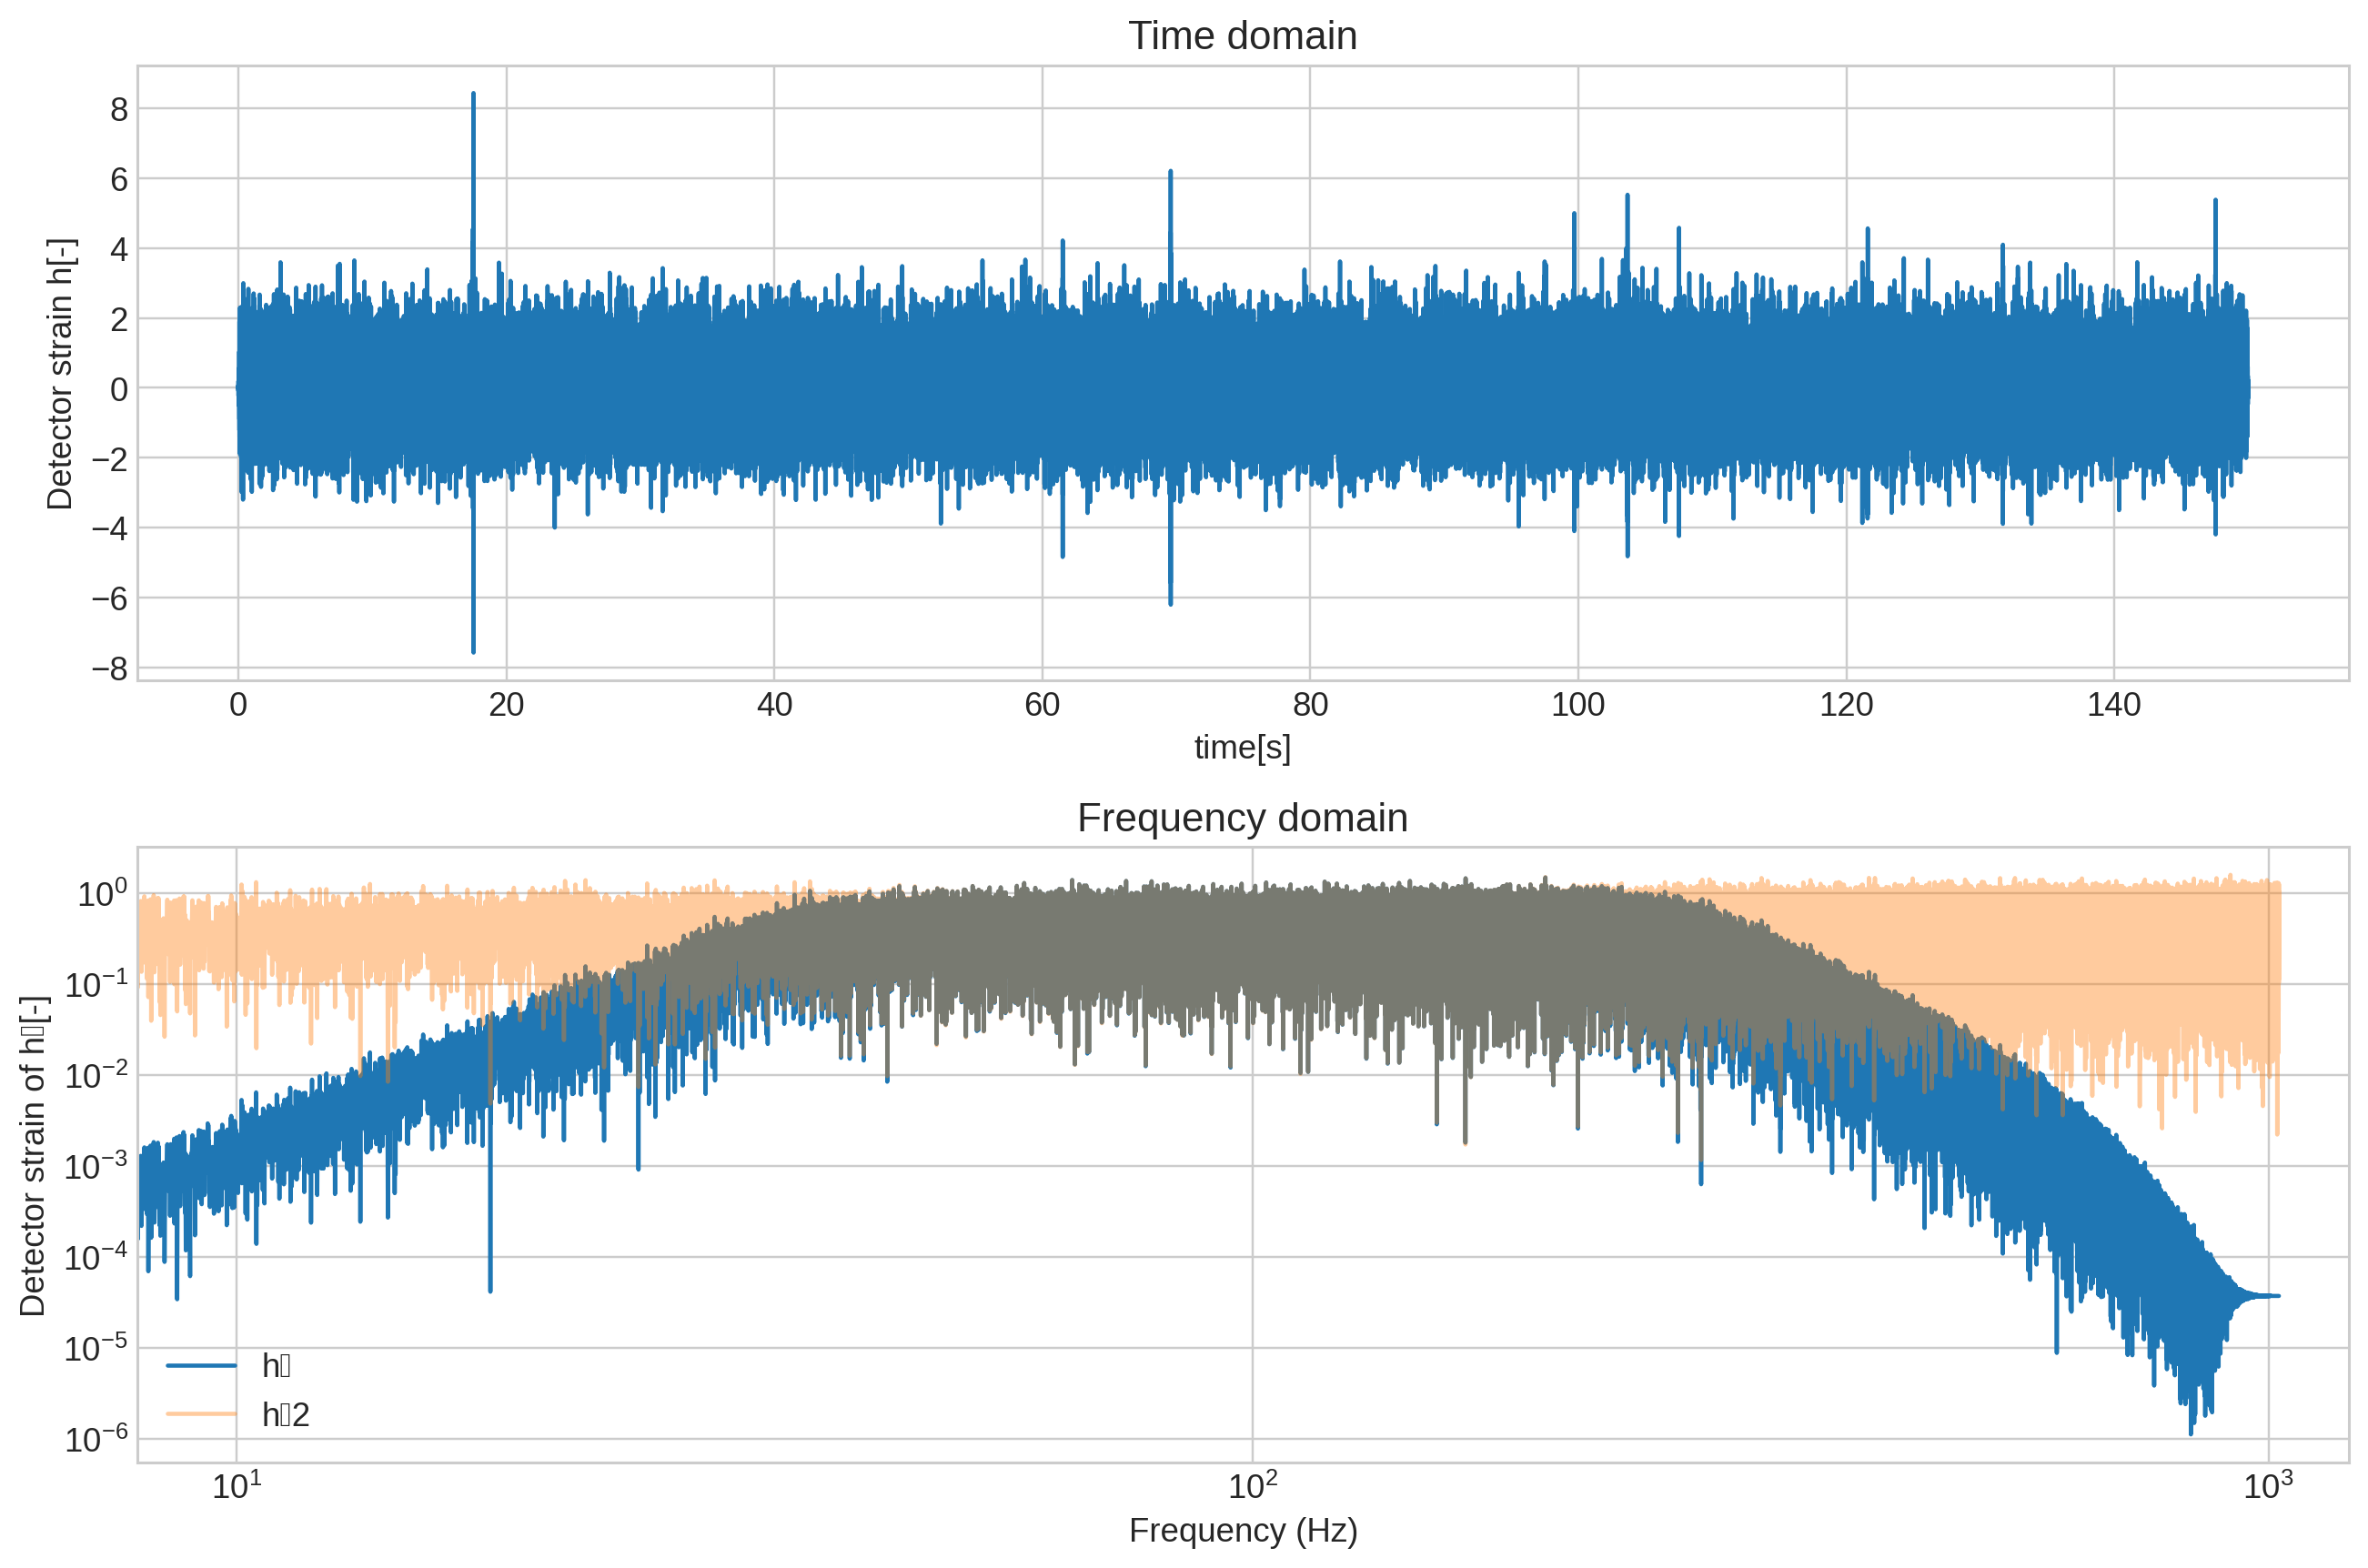

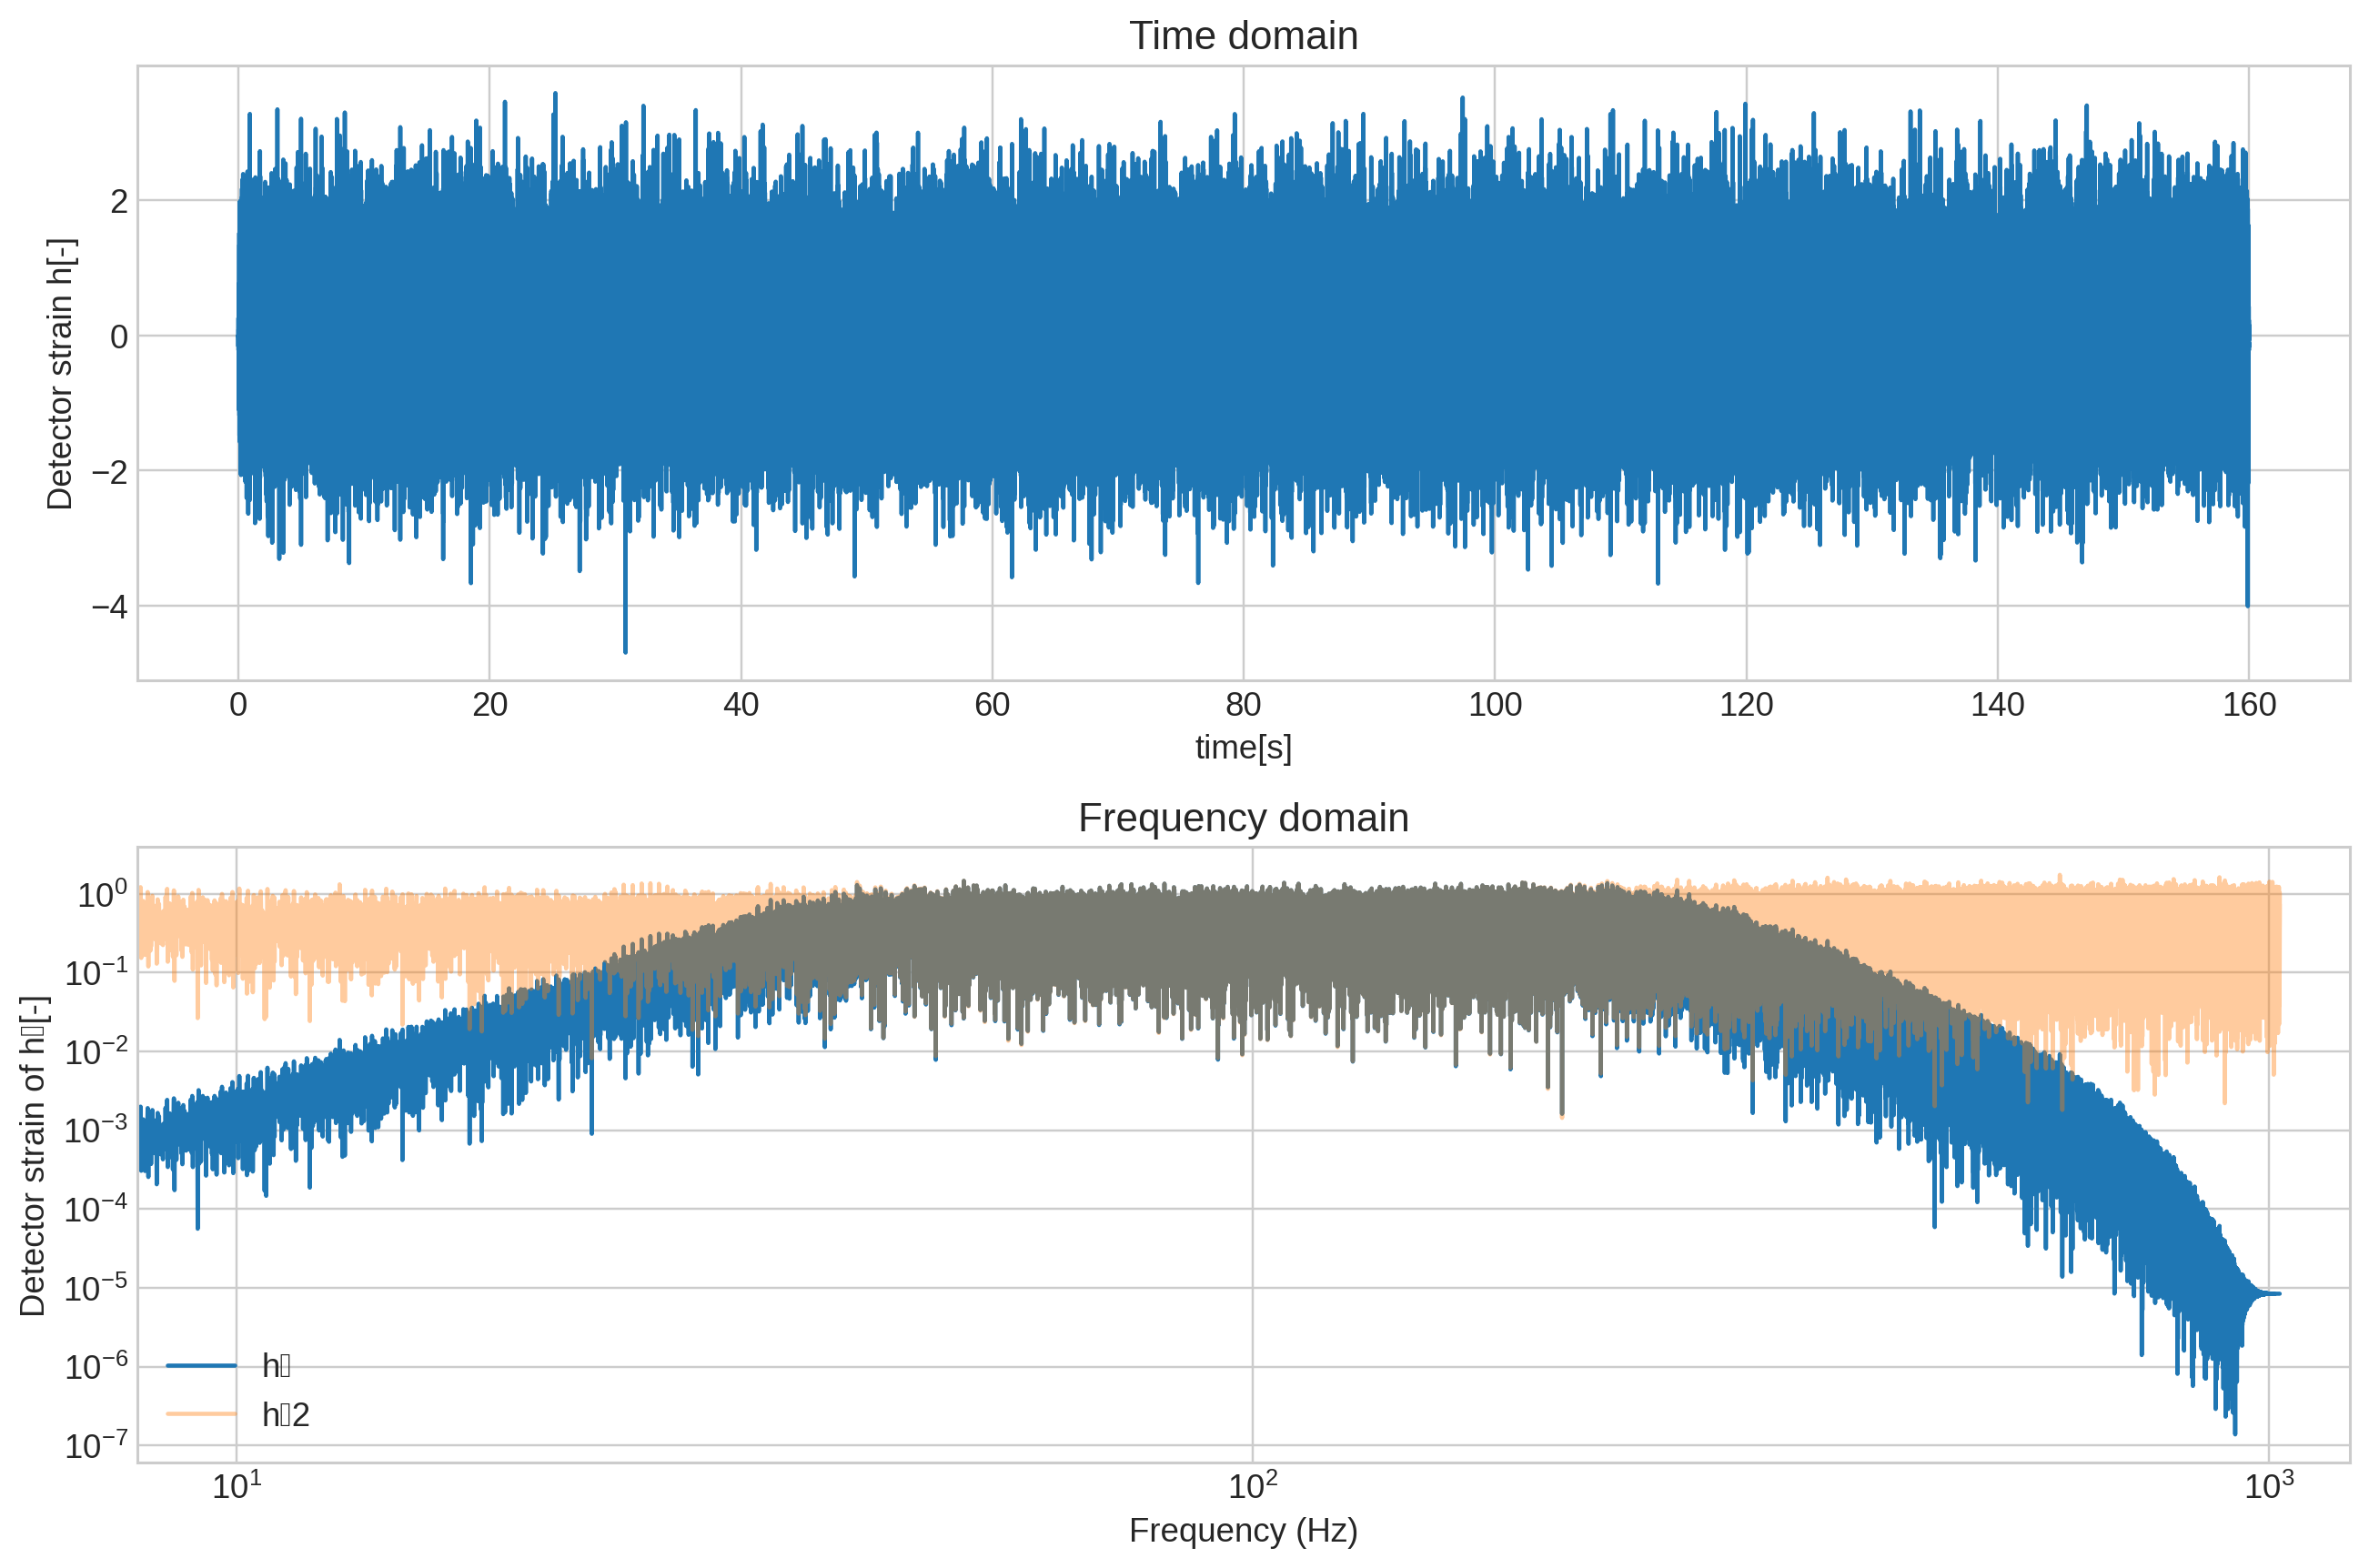

(PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ffa5a144f60>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ffa5a1eae48>)

In [24]:
responsetype = Bandpass(35, 265, fs=sampling_rate)
designmethod = Butterworth(4)
h_equalized_filter = filt(digitalfilter(responsetype, designmethod), h_equalized)
h̃_equalized_filter = dt * FFTW.rfft(h_equalized_filter) 
h_equalized_filter_in_sig = filt(digitalfilter(responsetype, designmethod), h_equalized_in_sig)
h̃_equalized_filter_in_sig = dt * FFTW.rfft(h_equalized_filter_in_sig) 

ax1, ax2 = plot_td_and_fd(h_equalized_filter_in_sig, h̃_equalized_filter_in_sig,  h̃_equalized_in_sig,)
ax1, ax2 = plot_td_and_fd(h_equalized_filter, h̃_equalized_filter,  h̃_equalized)


┌ Warning: the lowest frequency wavelet has more than 1% its max at zero, so it may not be analytic. Think carefully
│   lowAprxAnalyt = 0.06187729472306093
└ @ ContinuousWavelets /home/yuri/.julia/packages/ContinuousWavelets/a0IUF/src/sanityChecks.jl:6
┌ Warning: the lowest frequency wavelet has more than 1% its max at zero, so it may not be analytic. Think carefully
│   lowAprxAnalyt = 0.06187729472306093
└ @ ContinuousWavelets /home/yuri/.julia/packages/ContinuousWavelets/a0IUF/src/sanityChecks.jl:6


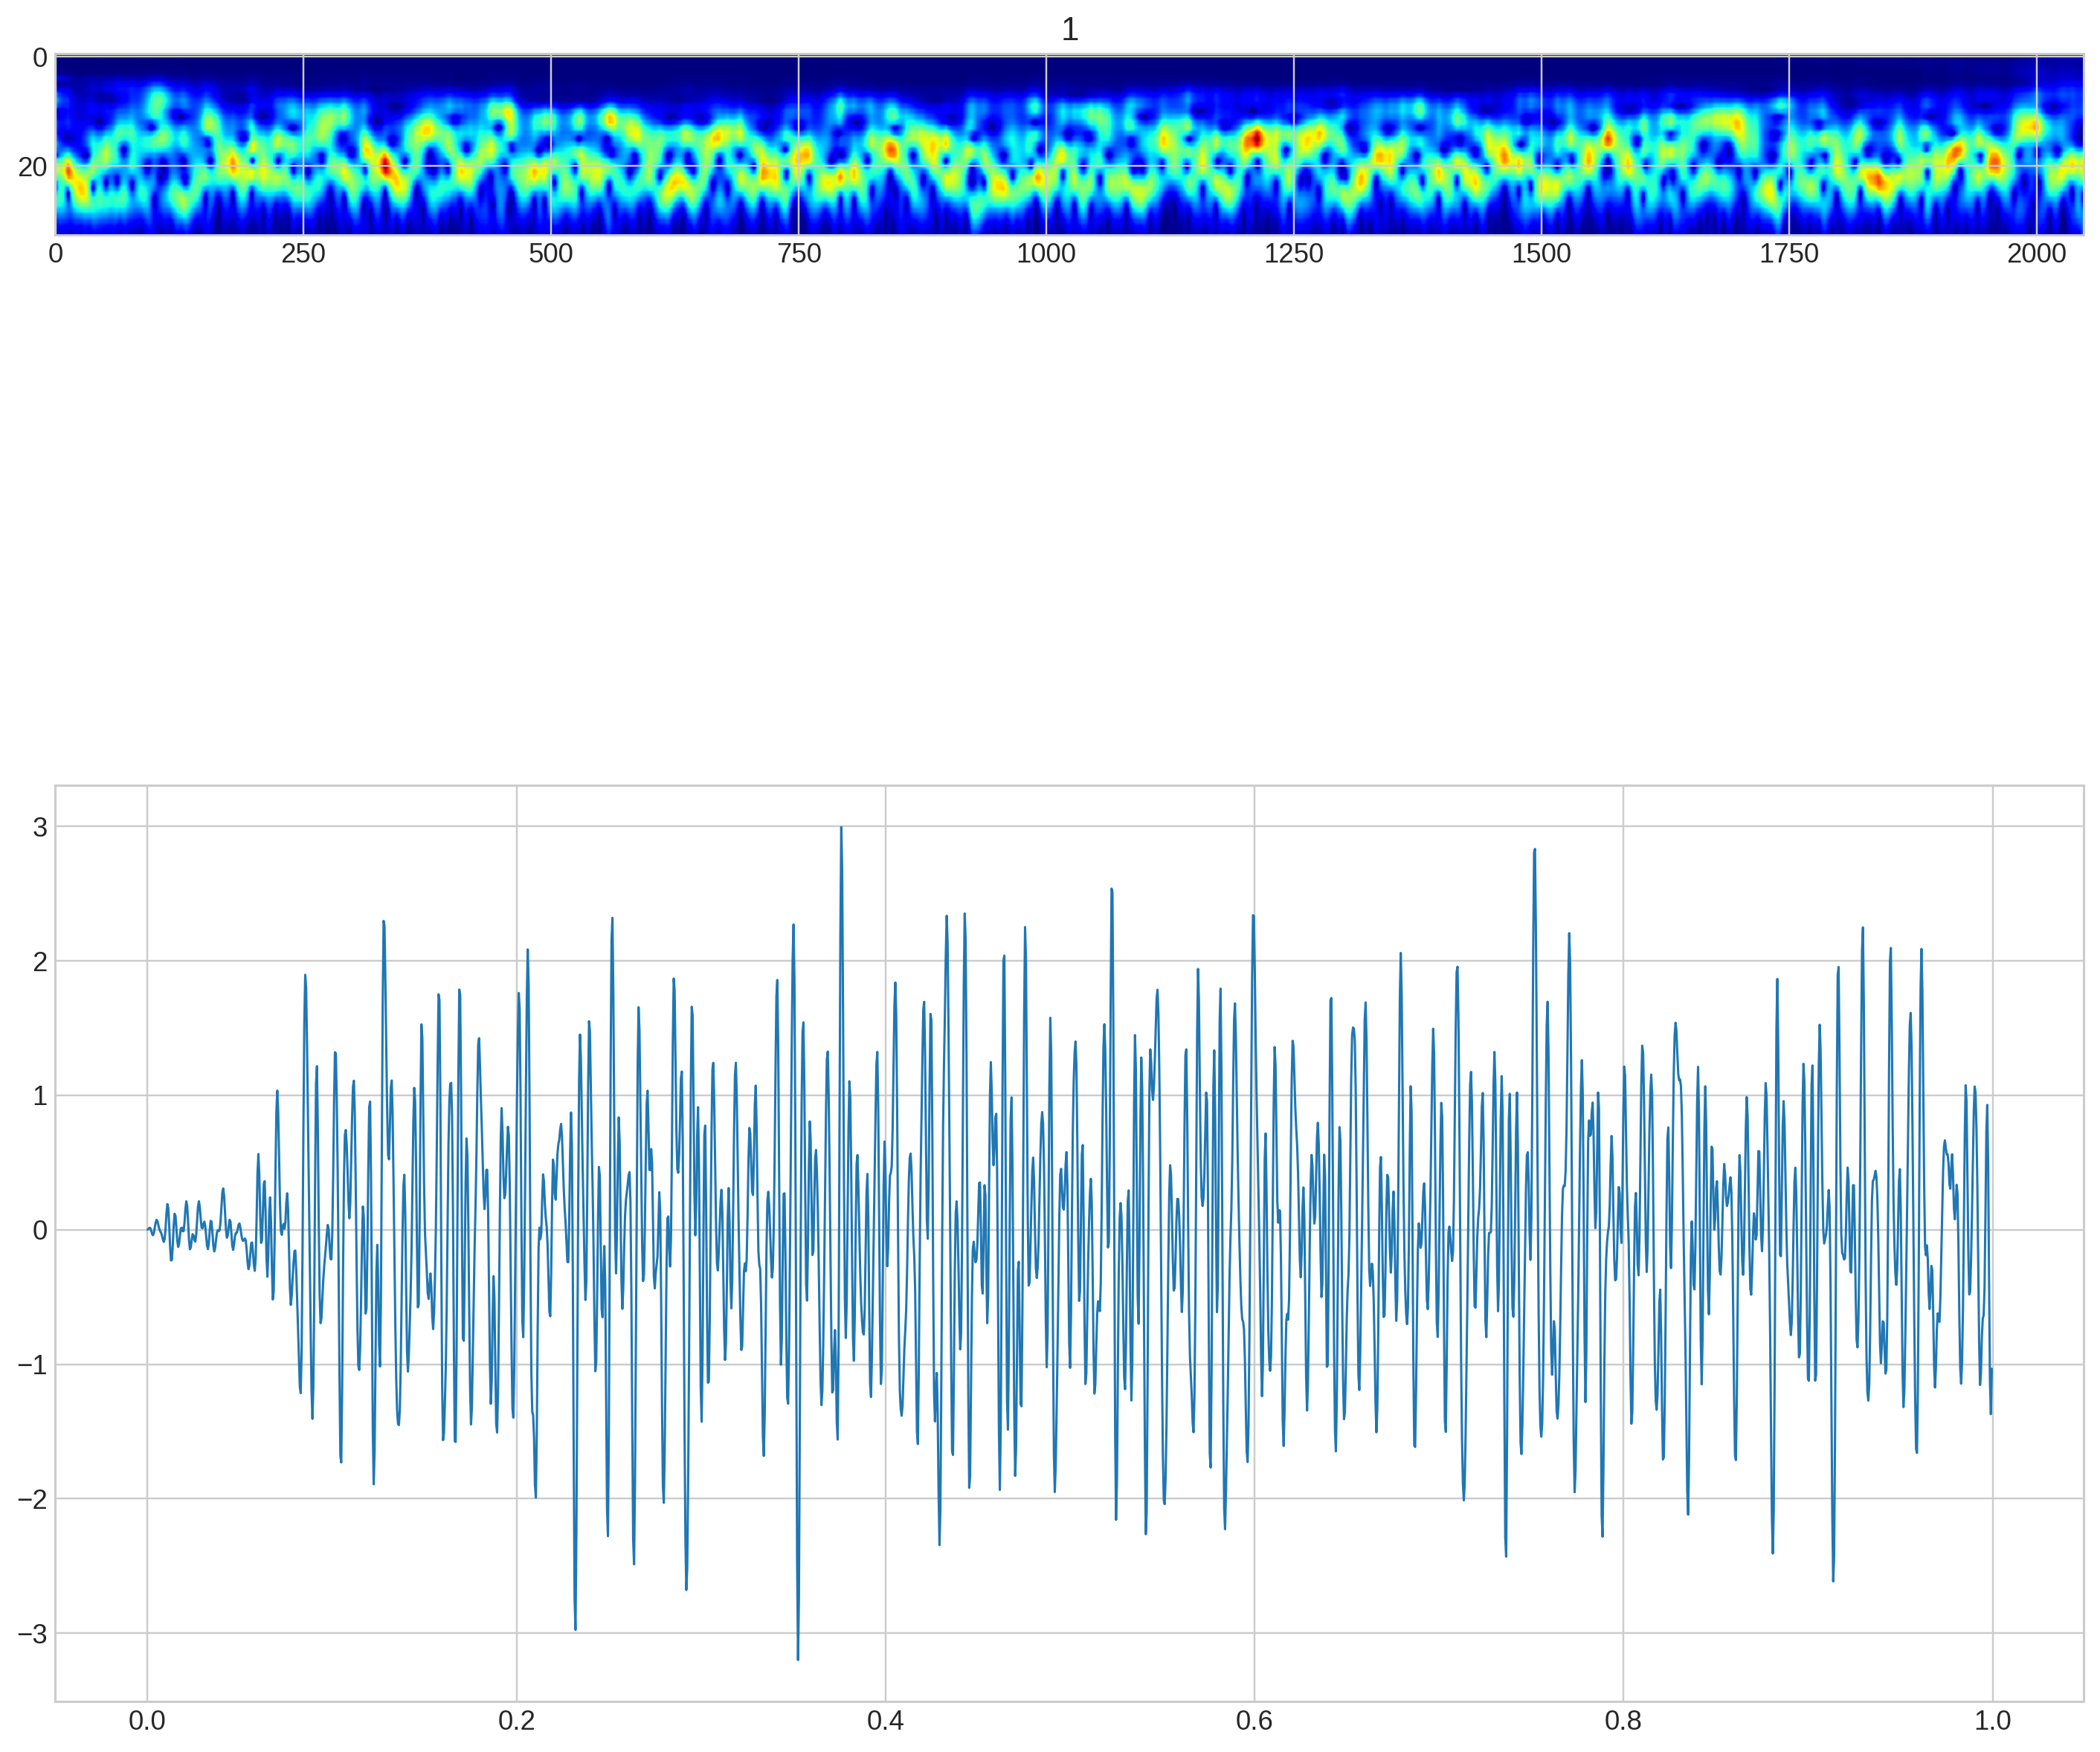

PyObject Text(0.5, 1.0, '1')

In [56]:
function sample_plot(t, h, flg)
    fig, (ax1, ax2) = plt.subplots(2,1)
    c = wavelet(Morlet(π), β=2);
    res = ContinuousWavelets.cwt(h, c)
    # plotting
    freqs = getMeanFreq(ContinuousWavelets.computeWavelets(sampling_rate, c)[1])
    freqs[1] = 0
    s = size(res, 2)
    res_p = abs.(res)' # |> a-> a[s:-1:1, :] |> Array
    res_p = res_p ./ sum(res_p,dims=1)
    # @show(sum(res_p,dims=1))
    ax1.imshow(res_p, aspect=2048/37/10, cmap="jet")
    # ax1.contourf(res_p, cmap="jet")
    ax2.plot(t, h, lw=1)
    ax1.set_title(flg)
end

t, s= select_detail(h_equalized_filter_in_sig, 0.0, 1.0)
sample_plot(t, s ,1)


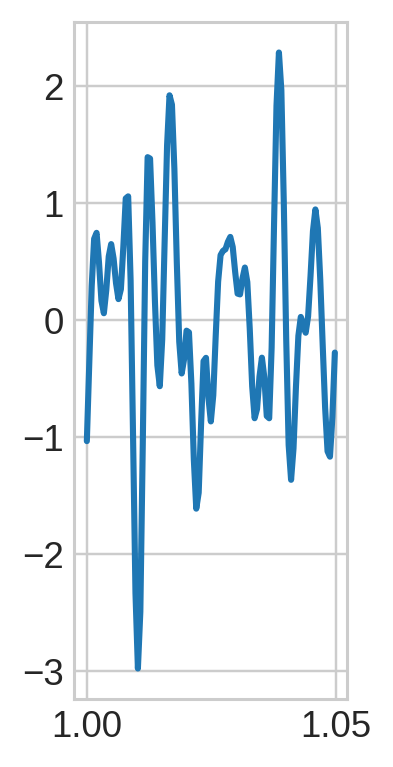

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffa5315c320>

In [58]:
function select_detail(h, t0, t1)
    idx0 = max(floor(Int, t0*sampling_rate), 1)
    idx1 = floor(Int, t1*sampling_rate)
    t = (collect(idx0:idx1) .-idx0) ./sampling_rate .+ t0 
    return t, h[idx0:idx1]
end

function plot_detail(h, t0, t1)
    t, h_detail = select_detail(h, t0, t1)
    fig, ax = plt.subplots(figsize=(16*(t1-t0)/0.5,4))
    ax.plot(t, h_detail, lw=2)
end

plot_detail(h_equalized_filter_in_sig, 1.0, 1.05)

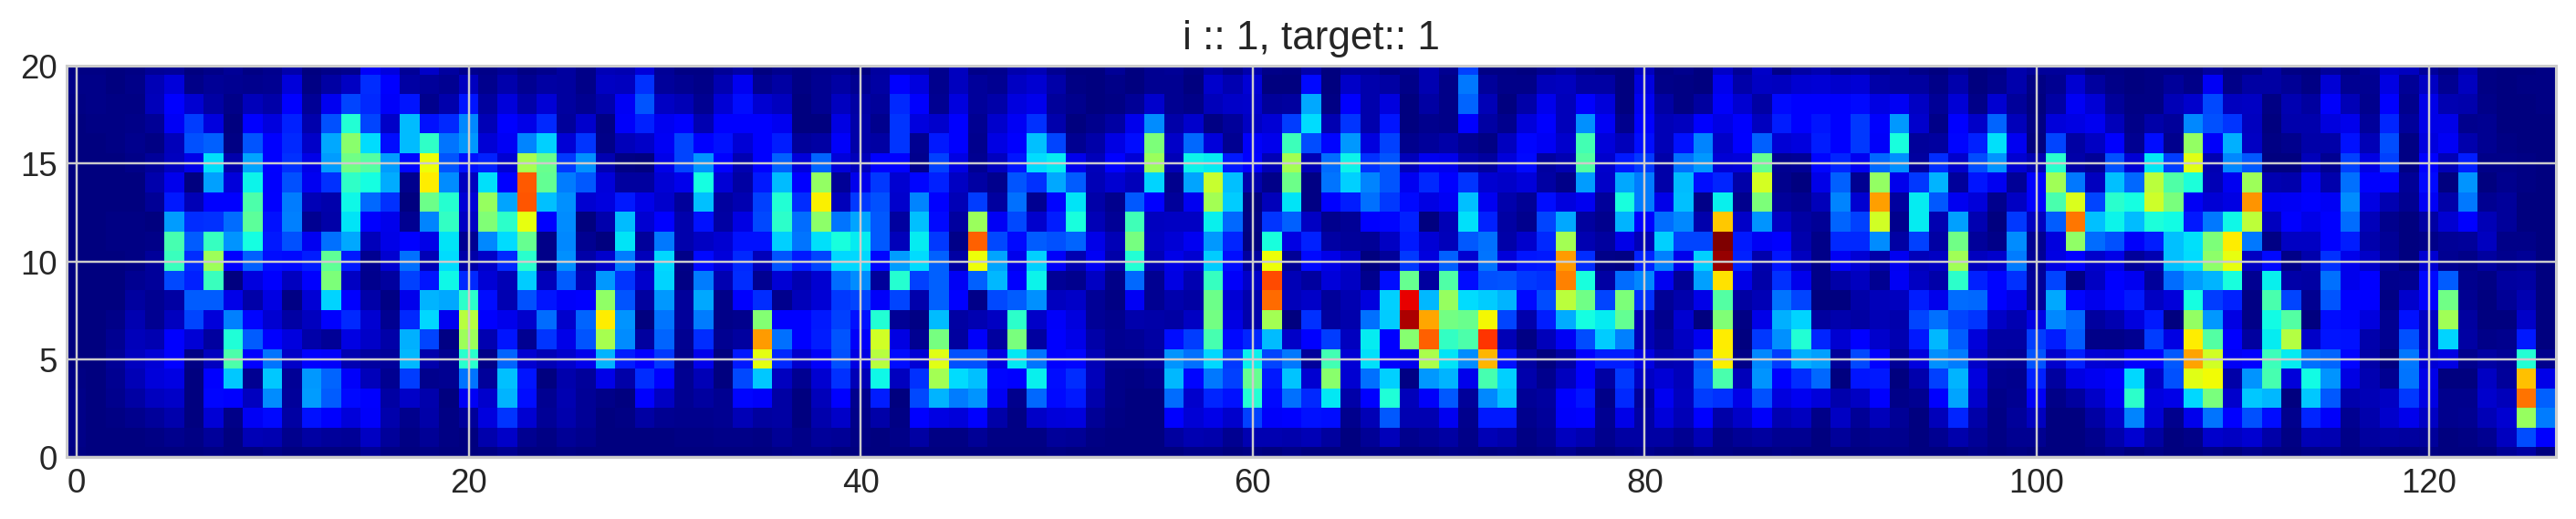

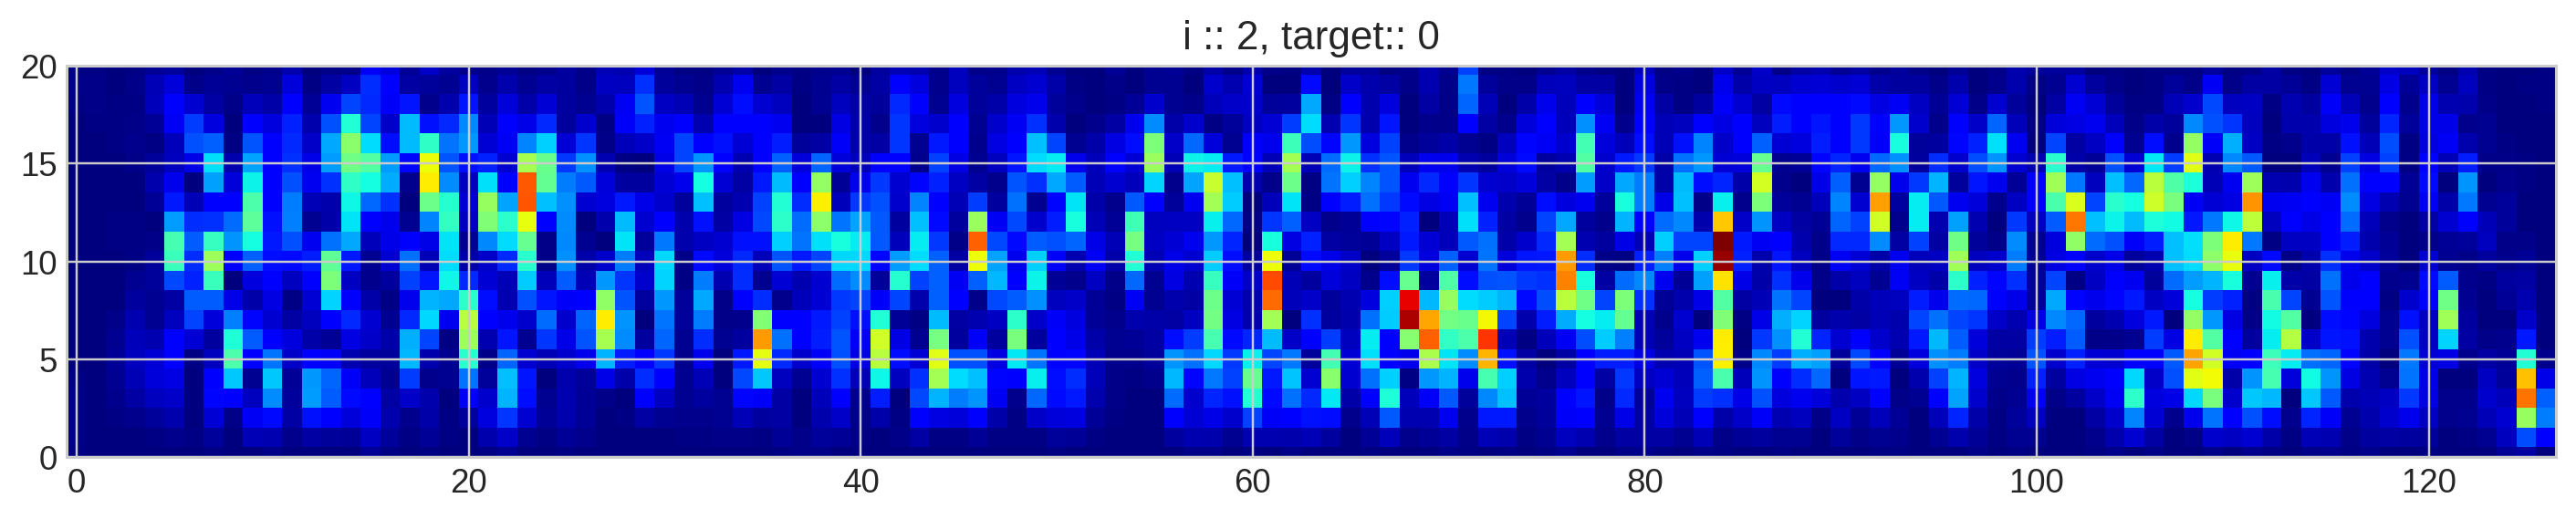

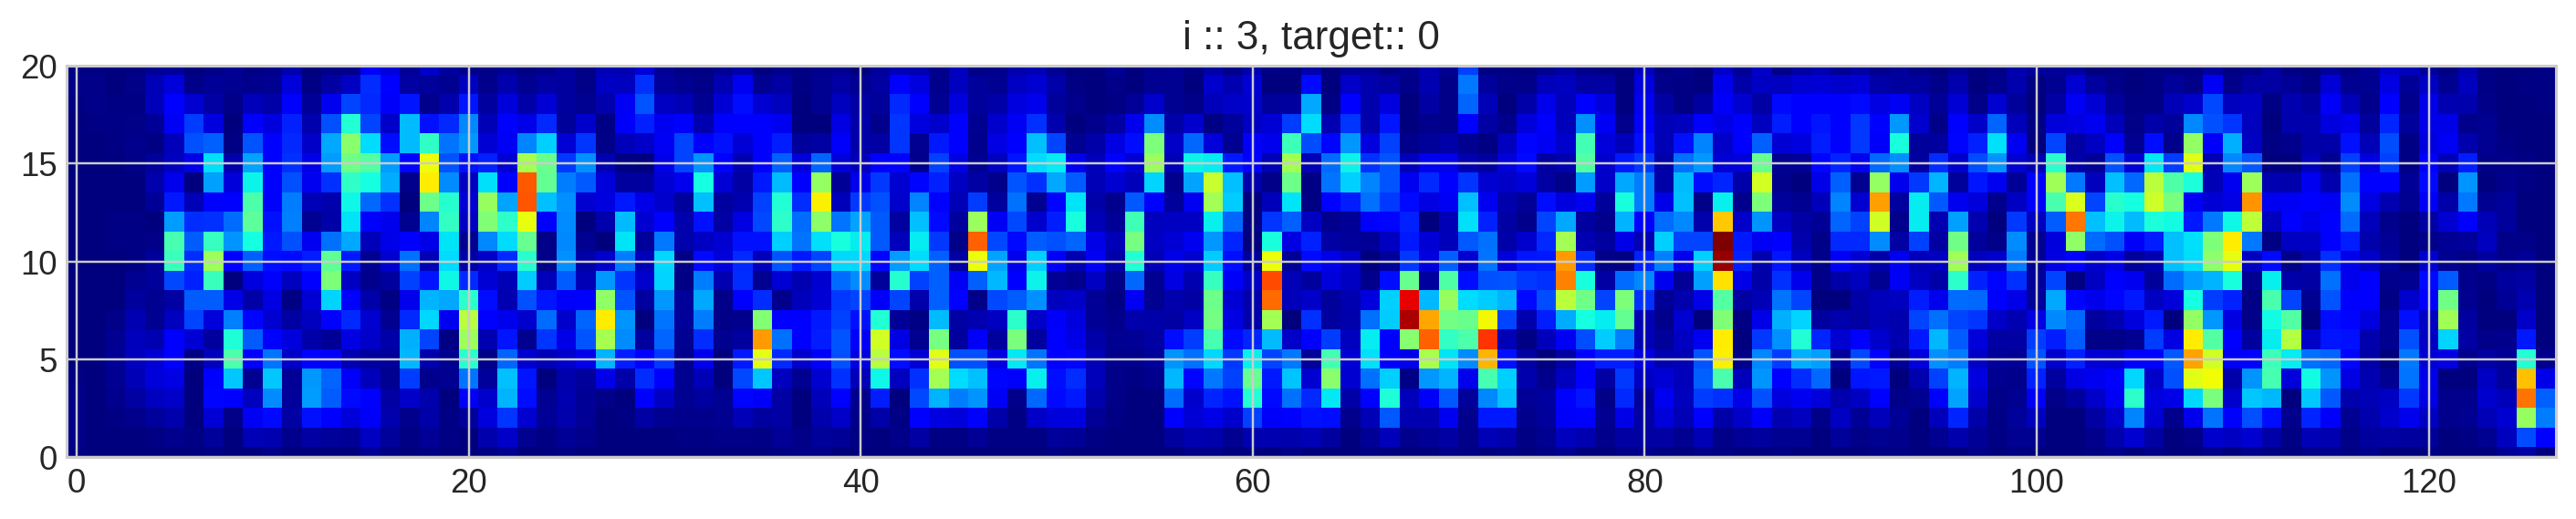

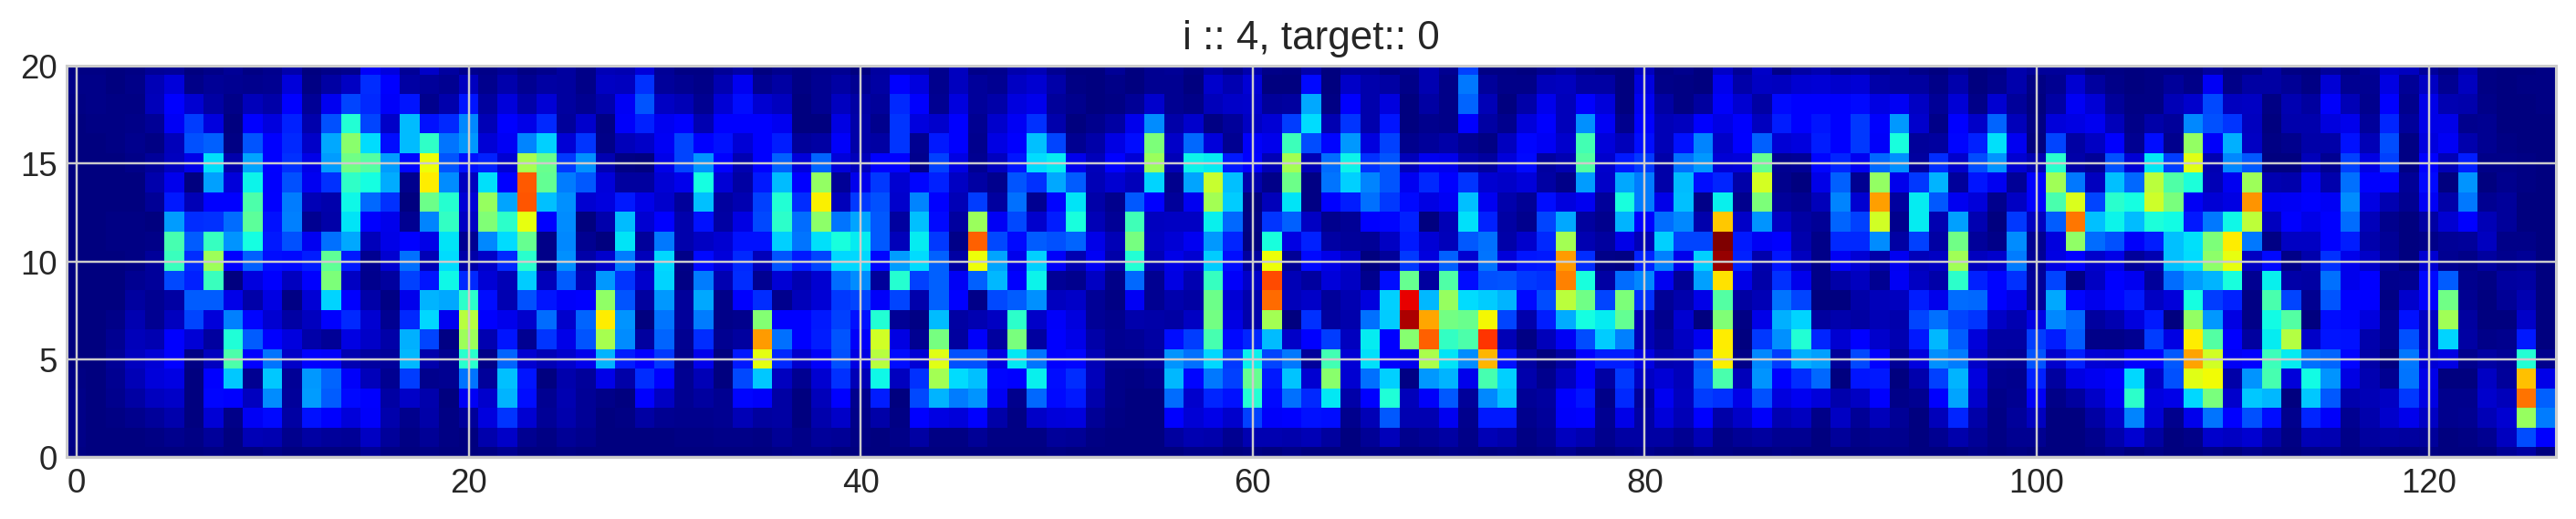

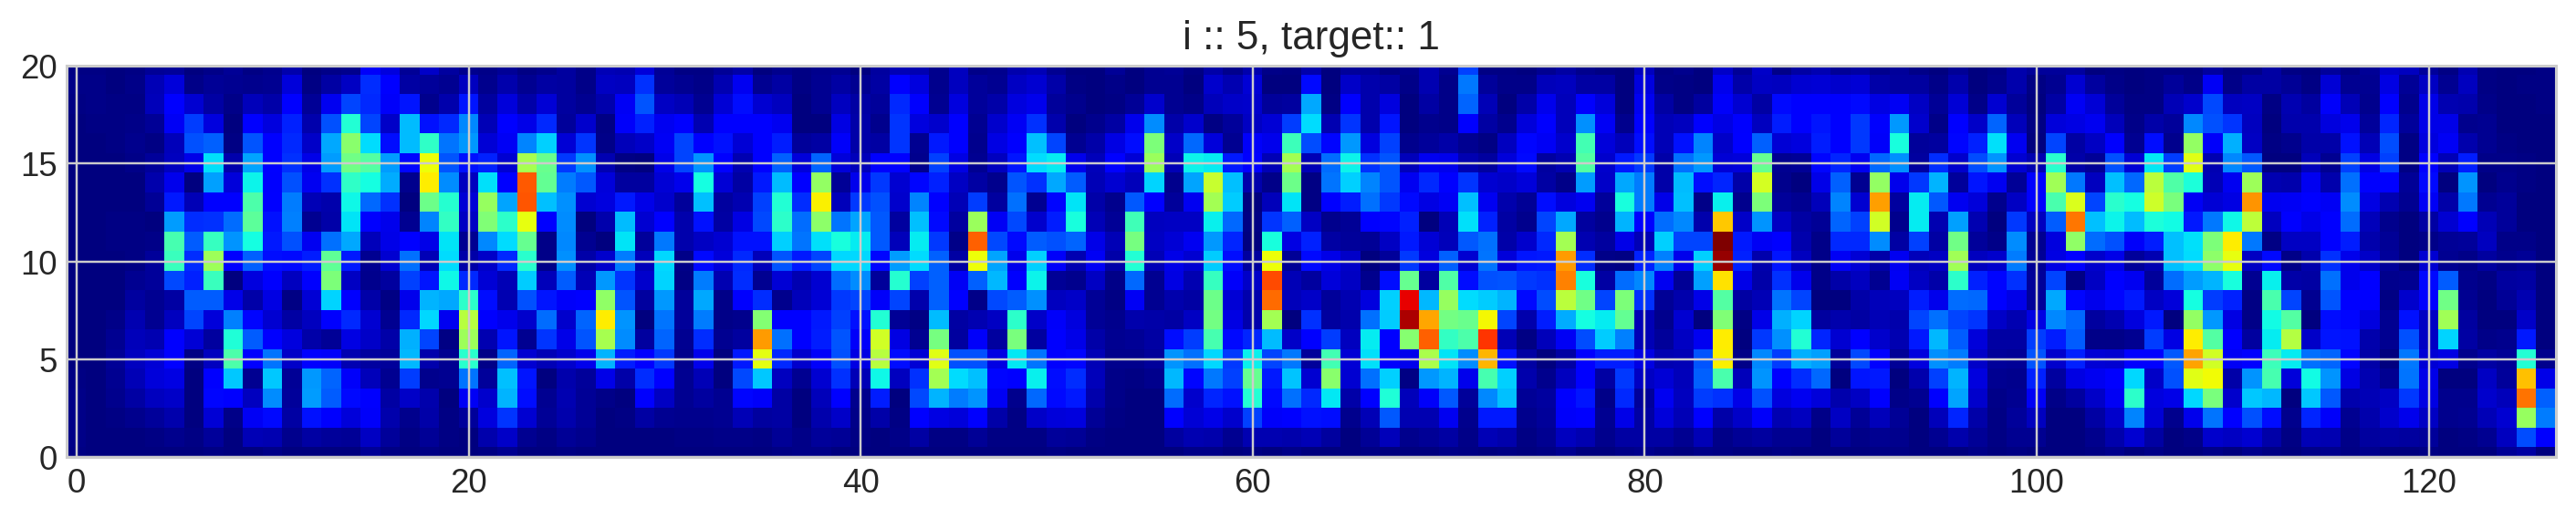

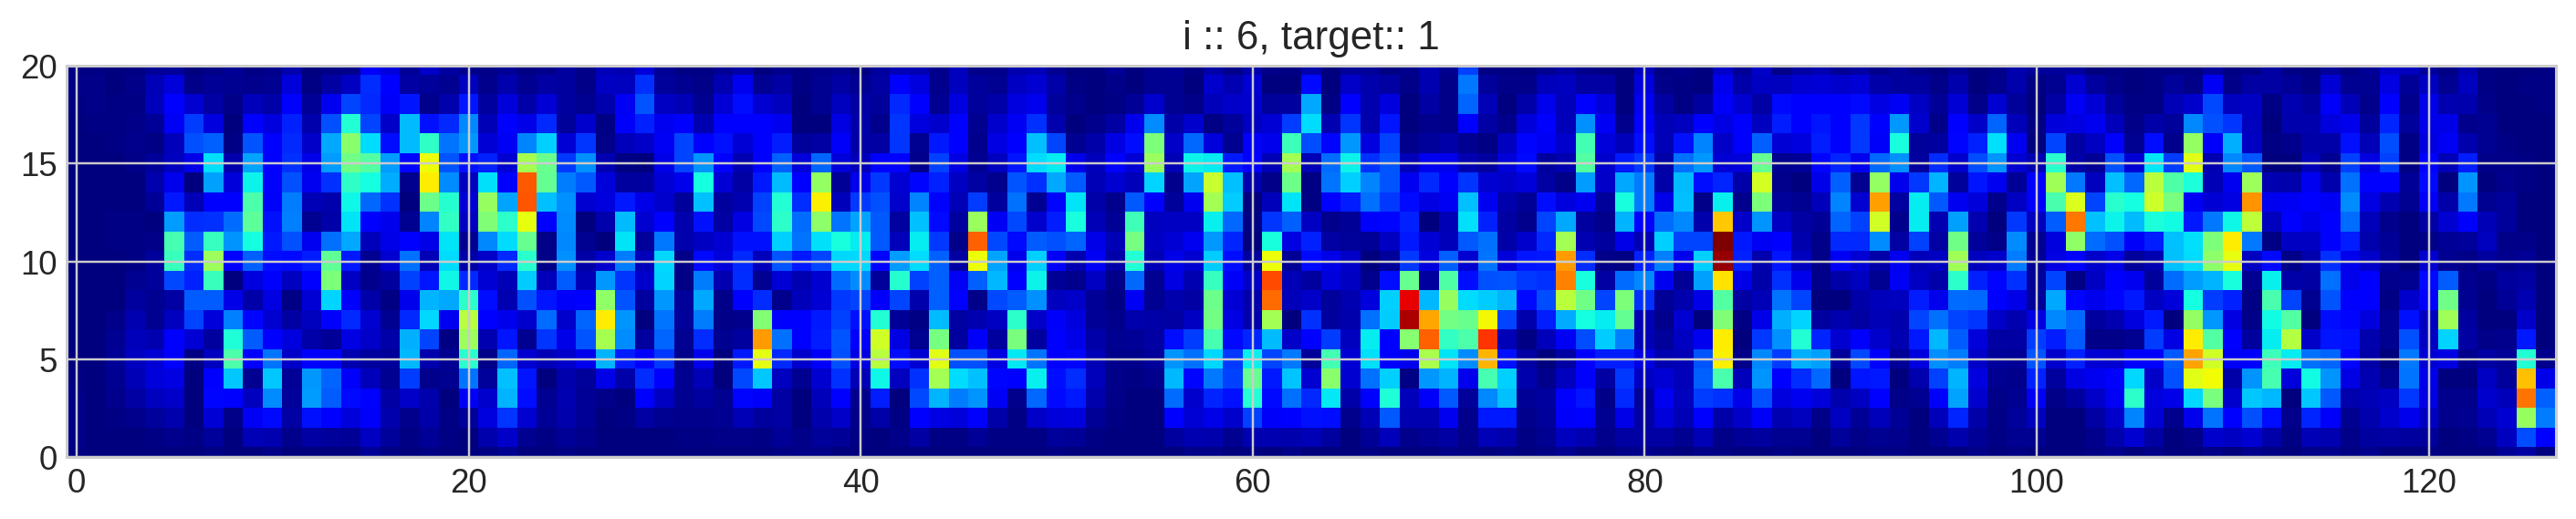

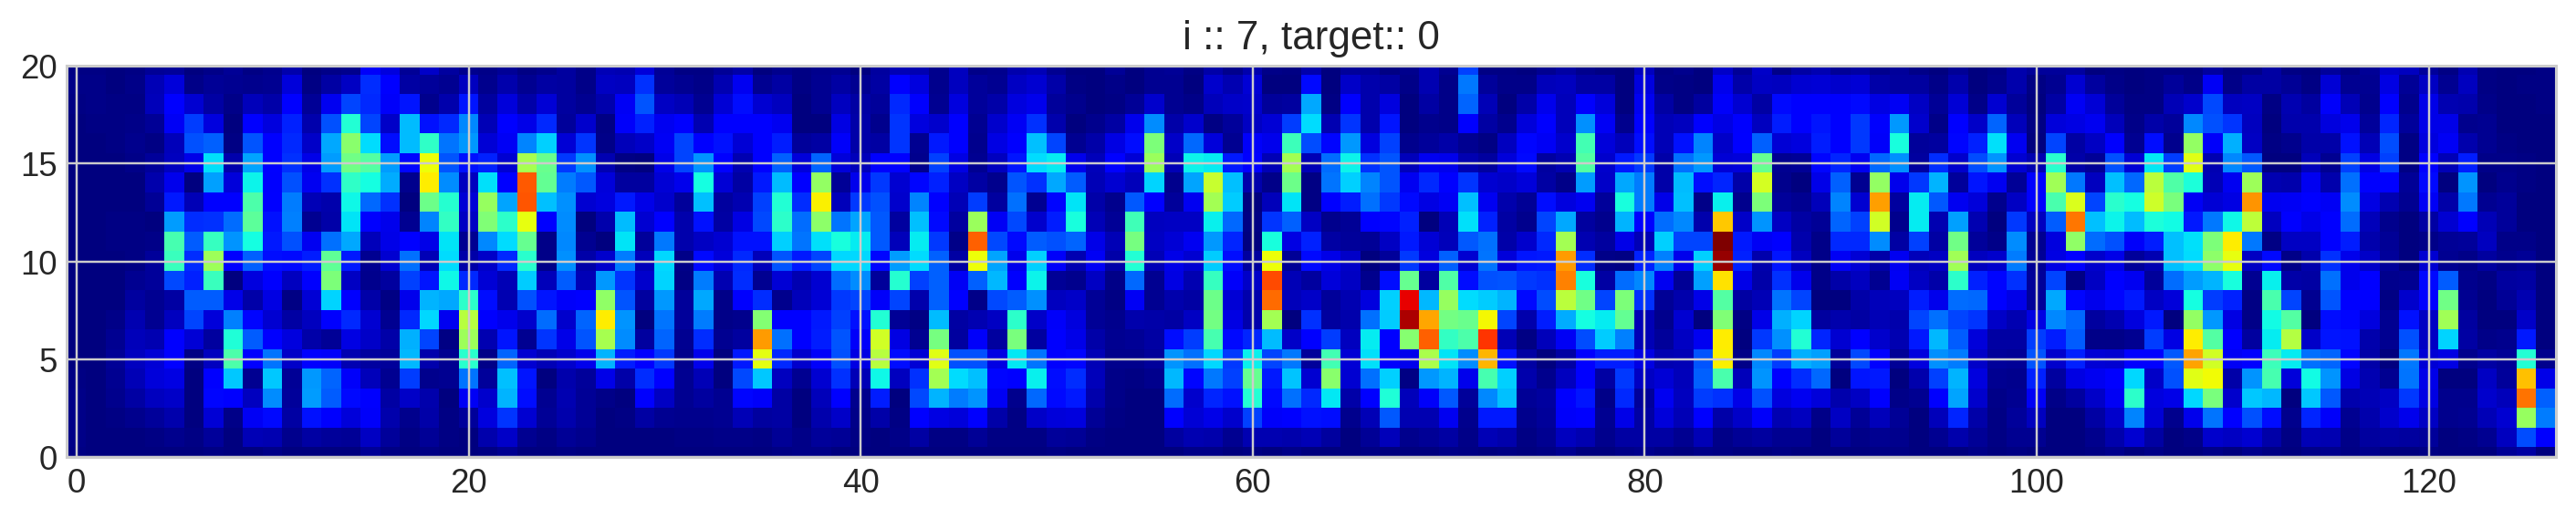

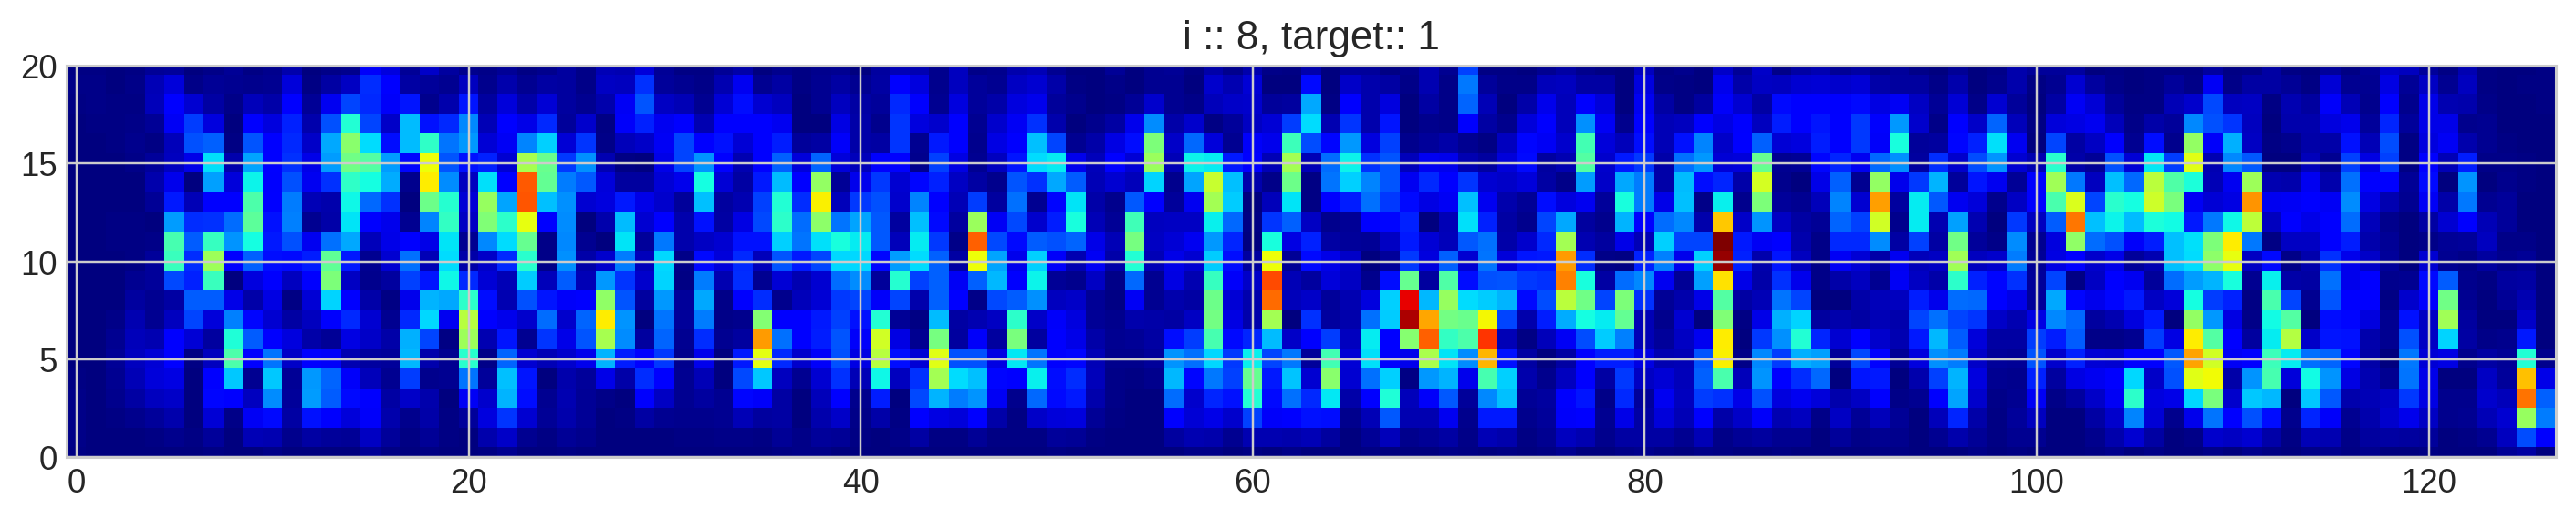

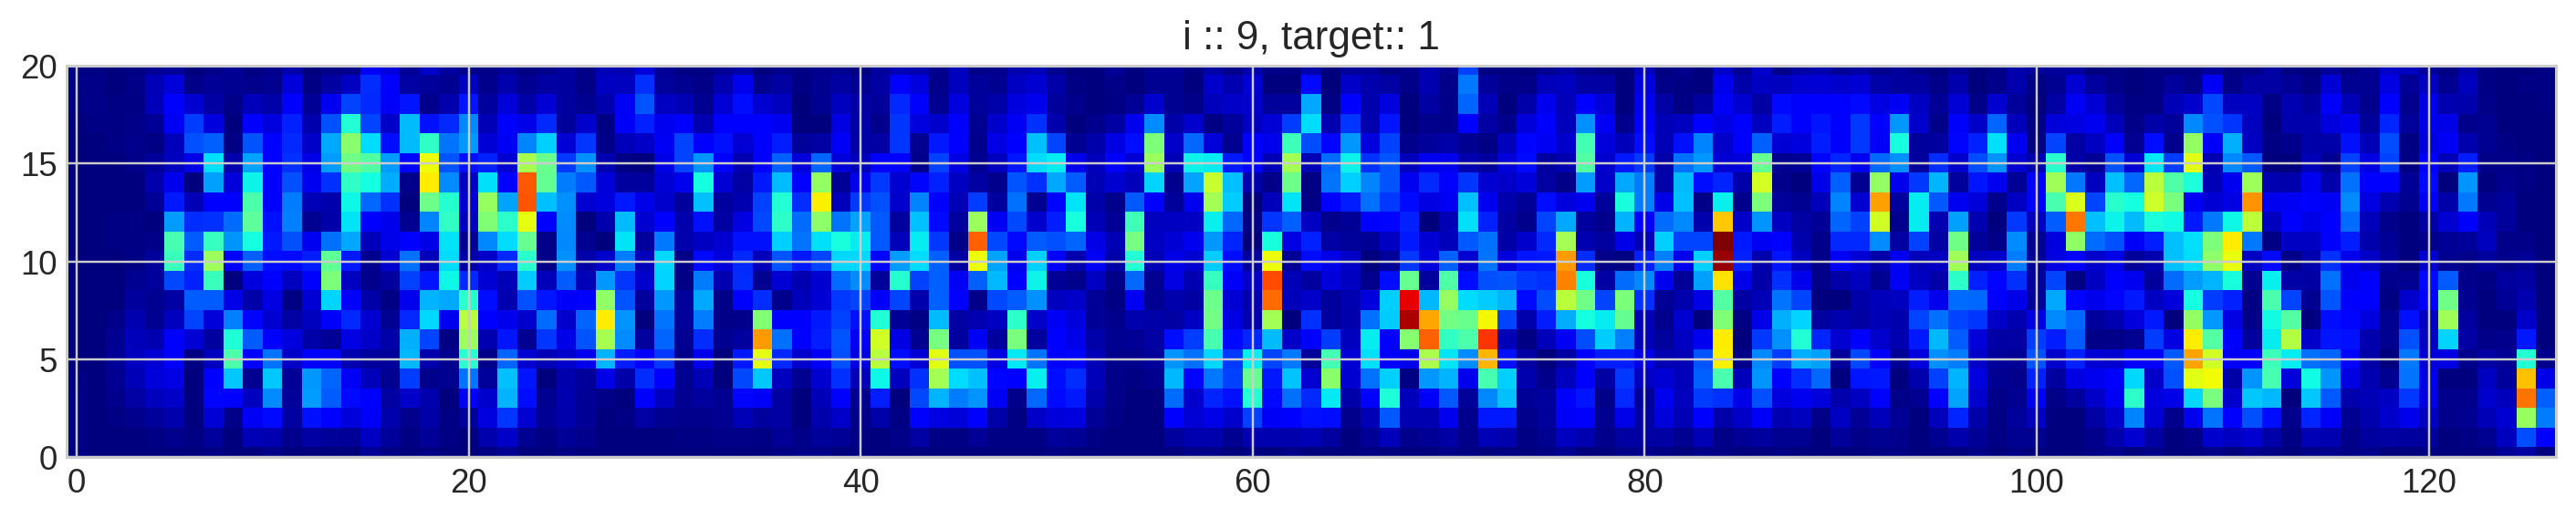

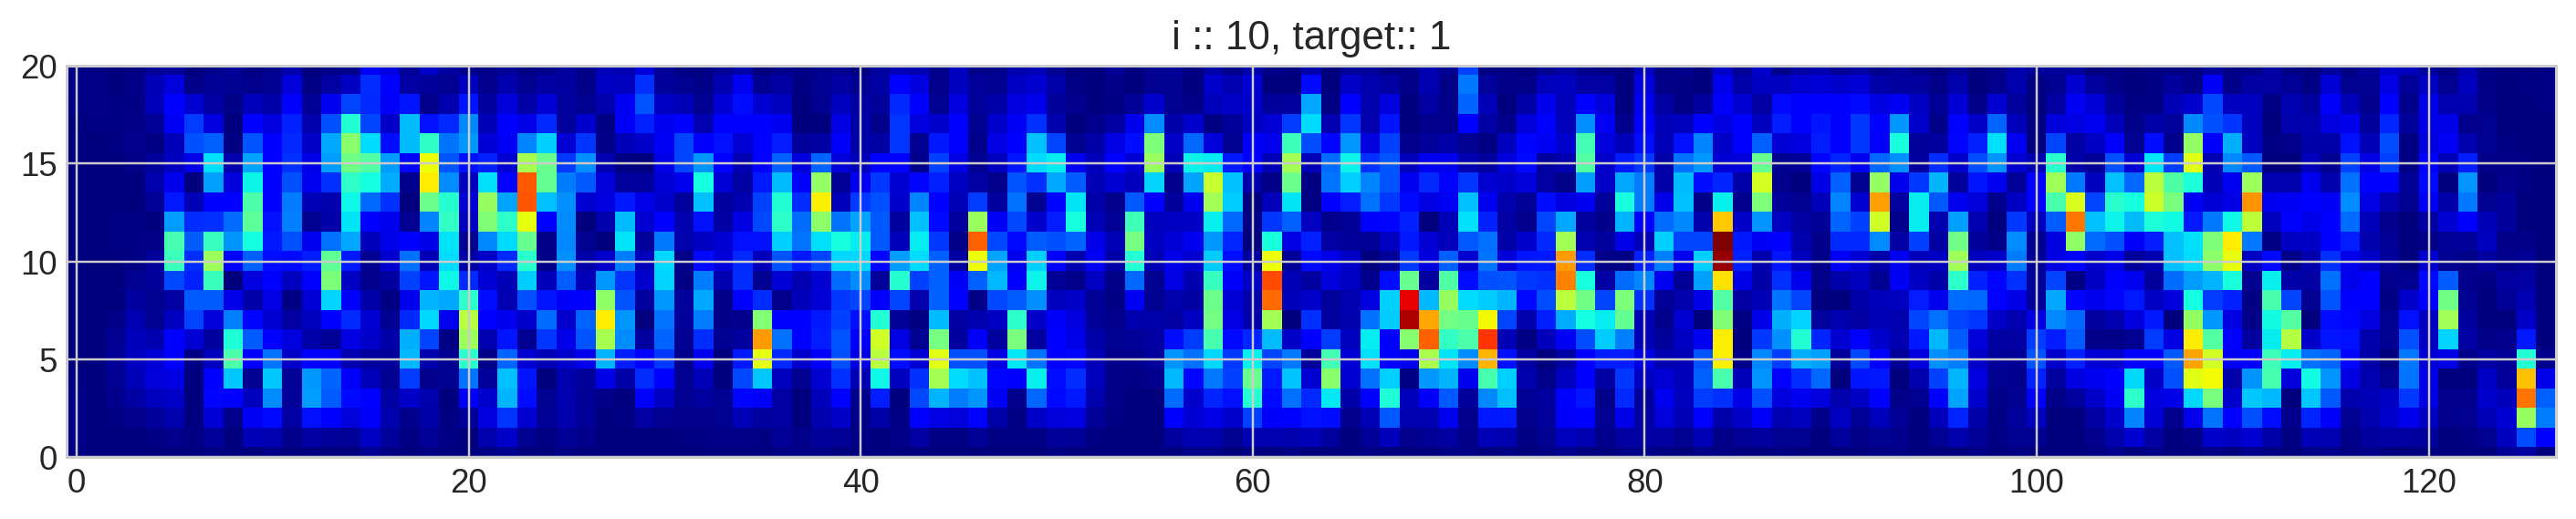

In [57]:
winsize = 64;
hopsize = 32;
n = 4096
for i in 1:10
    S = spectrogram(h_equalized_filter[n+1:n*2], winsize, winsize-hopsize,
        nfft=winsize*2, fs=sampling_rate, window=hanning);
    fig,ax = plt.subplots()
    ax.imshow(S.power, aspect=1, cmap="jet")
    ax.set_ylim(0,20)
    ax.set_title("i :: $i, target:: $(train_label_df[i, :target])")
end


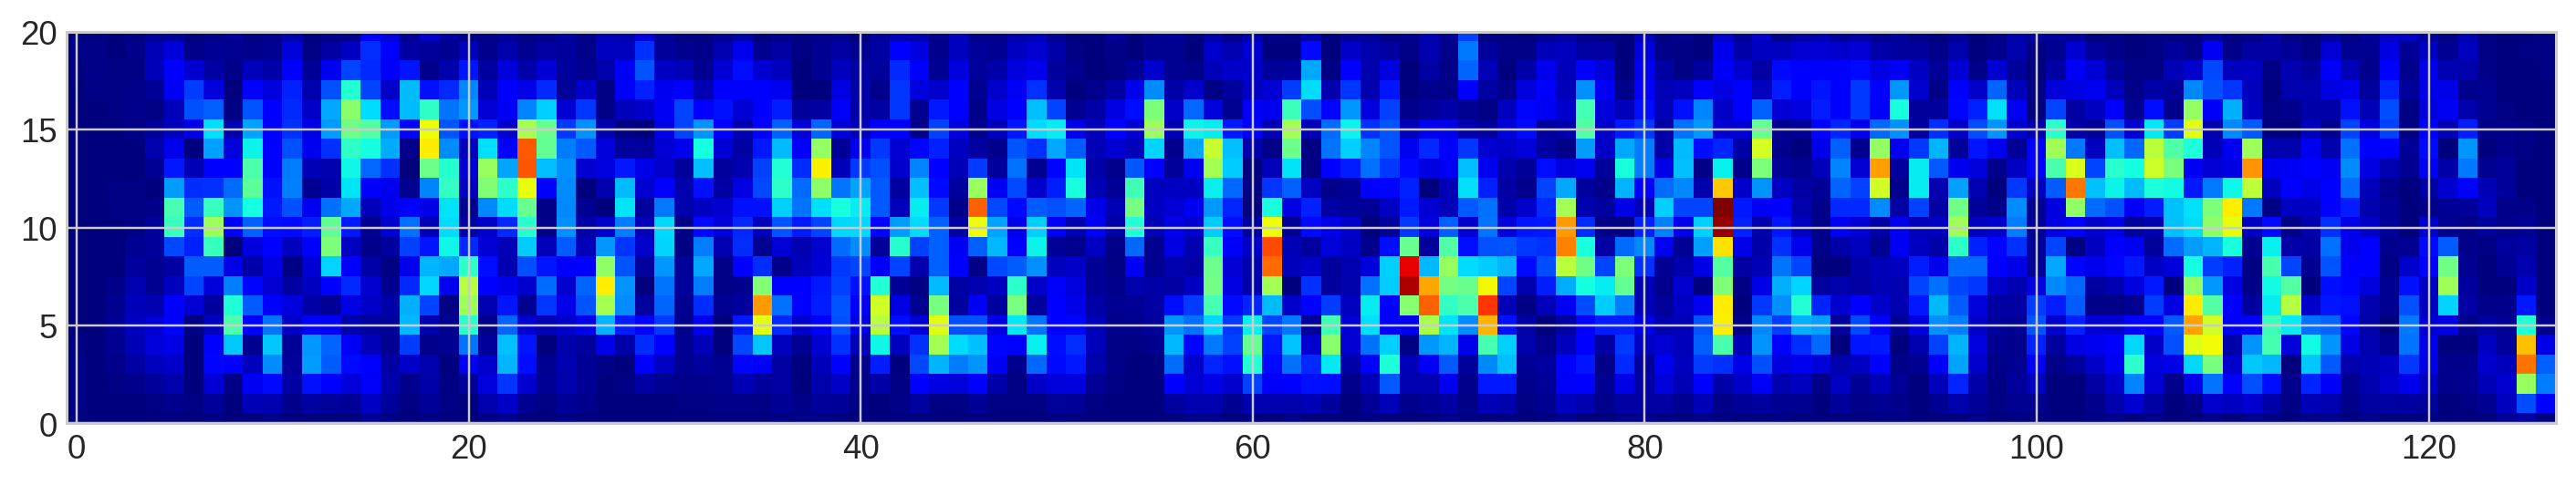

(0.0, 20.0)

In [54]:
S.time


In [48]:
S.power
collect(S.time) |> size

(31,)